# 서울/수도권 출퇴근 시간 로드지퍼로 Zip! 하자 🚗

## - 서울/수도권 출퇴근 정체를 해결을 위한 로드지퍼 위치 제안 및 차선 확대 효과 예측 

![image-3.png](attachment:image-3.png)

---

# 목차
### 서론 1. 분석 배경
   * 1-1. 서울/경기 인구 수 및 차량 통행 지표
   * 1-2. 출퇴근 교통 체증문제 해결책 : BTX 도입
   * 1-3. 로드지퍼 필요성 및 정의
   
### 본론 2. 데이터 전처리
   * 2-1 속도 데이터
   * 2-2 교통량 데이터 
   * 2-3 서울시 표준 노드와 속도 데이터 링크아이디 매핑 
   * 2-4) 속도,교통량 모두 있는 지점 선정 
   * 2-5) 속도데이터에 상/하행 속도 차이 추가
   * 2-6) 교통량 데이터에 상/하행 교통량 차이 추가
   * 2-7) 속도 데이터와 교통량 데이터 합치기 
   * 2-8) 지점별 시간대별 교통 밀도 추가
   * 2-9) 지점별 CCTV, 진입로, 교차로 ,신호등 갯수 추가  
   
### 본론 3. 모델링
   * 3-1. 군집분석
   * 3-2. 최종 군집 EDA
   * 3-3. 최종 로드지퍼 설치 위치 제안 
   
### 본론 4. 로드지퍼 설치 효과 
   * 4-1. 지점/상하행별 임계속도 분석
   * 4-2. 차선 확대에 따른 임계속도 예측 
   
### 결론 5. 로드지퍼 활용 방안  
   * 5-1. 로드지퍼 활용 방안 

***

# 서론

## 1. 분석 배경 

### 1-1) 서울/경기 인구수 및 차량 통행 지표

![image.png](attachment:image.png)

- 수도권 인구수(2601만)가 전체 인구수(5167만)의 50% 돌파
- 경기도 > 서울 > 인천 순으로 인구수 많음

#### -> 경기도 인구수가 가장 많지만 서울특별시의 교통량과 교통혼잡도가 제일 심함
#### -> 즉, 경기도에서 서울로 통근 하는 사람이 多, 서울 활동 인구수에 다수의 경기도민이 포함됨

### 1-2) 출퇴근 교통 체증문제 해결책 : BTX 도입

![image.png](attachment:image.png)

![image-6.png](attachment:image-6.png)

### 1-3) 로드지퍼란 ? 

![image-2.png](attachment:image-2.png)

![image.png](attachment:image.png)

### 장점 
* 필요에 따라 중앙분리대를 움직여 교통 체증 완화 가능
* 충돌방지 시스템으로 교통사고 방지
* BRT, BTX 도입시킬 수 있어, 경기도민의 통근시간 감축 가능 

### 개선기회
* 사업비가 많이 든다.(설치 차량 40억)
* 1km 설치 당 약 32억원 필요
* 로드지퍼 설치 끝나는 부분의 병목현상 발생 될 수 있음 

![image-3.png](attachment:image-3.png)

---

# 본론

## 2. 데이터 전처리

### <사용 데이터>

* 서울시 링크/노드 데이터 
* 서울시 SHP 파일 [http://www.gisdeveloper.co.kr/?p=2332]
* Topis 도로별 일자별 통행속도 데이터[https://topis.seoul.go.kr/refRoom/openRefRoom_1.do]
* Topis 서울시 교통량 데이터 [https://topis.seoul.go.kr/refRoom/openRefRoom_2.do]
* ITS 표준노드, 링크아이디 매핑 데이터 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import geopandas as gpd
from IPython.display import Image
matplotlib.rc('font',family='NanumGothic')
plt.rc('font',family='NanumGothic')

### 2-1) 속도 데이터 

#### 서울시 차량통행속도 데이터
#### 수집기간 : 2021년 01 ~ 06월, 24시간 (00~24시)
#### 수집범위 : 서울특별시 485개도로

* Topis 서울시 도로별 일자별 통행속도 데이터 중 2021년 01~06월까지 데이터 다운 후, csv 변환
- 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향(상/하행), 거리, 차선수,기능유형구분(보조간선도로/기타도로), 도심/외곽구분, 권역구분, 시간대별 속도로 구성 

In [ ]:
# 2021년 01 ~ 06월 속도 데이터 다운로드 
speed_01 = pd.read_csv('2021년 01월 서울시 차량통행속도.csv',encoding='cp949')
speed_02 = pd.read_csv('2021년 02월 서울시 차량통행속도.csv',encoding='cp949')
speed_03 = pd.read_csv('2021년 03월 서울시 차량통행속도.csv',encoding='cp949')
speed_04 = pd.read_csv('2021년 04월 서울시 차량통행속도.csv',encoding='cp949')
speed_05 = pd.read_csv('2021년 05월 서울시 차량통행속도.csv',encoding='cp949')
speed_06 = pd.read_csv('2021년 06월 서울시 차량통행속도.csv',encoding='cp949')

# 데이터 합치기
speed_21 = pd.concat([speed_01,speed_02,speed_03,speed_04,speed_05,speed_06])

In [ ]:
speed_21 =speed_21.dropna()

### 2-2) 교통량 데이터 

#### 서울시 교통량 데이터
#### 수집기간 : 2021년 01 ~ 06월, 24시간 (00~24시)
#### 수집범위 : 서울특별시 주요간선도로 및 도시고속도로

* Topis 서울시 교통량 데이터 중 2021년 01~06월까지 데이터 다운 후, csv 변환
* 일자, 요일, 지점명, 지점번호, 방향, 구분, 시간별 교통량으로 구성

In [ ]:
# 2021년 01 ~ 06월 교통량 데이터 다운로드 
traffic_01 = pd.read_csv('01월 서울시 교통량 조사자료.csv',encoding='cp949')
traffic_02 = pd.read_csv('02월 서울시 교통량 조사자료.csv',encoding='cp949')
traffic_03 = pd.read_csv('03월 서울시 교통량 조사자료.csv',encoding='cp949')
traffic_04 = pd.read_csv('04월 서울시 교통량 조사자료.csv',encoding='cp949')
traffic_05 = pd.read_csv('05월 서울시 교통량 조사자료.csv',encoding='cp949')
traffic_06 = pd.read_csv('06월 서울시 교통량 조사자료.csv',encoding='cp949')

# 데이터 합치기
traffic_21 = pd.concat([traffic_01,traffic_02,traffic_03,traffic_04,traffic_05,traffic_06])

### 2-3) 서울시 표준 링크와 속도 데이터의 링크아이디 매핑

#### 서울시 표준 링크와 속도 데이터의 링크아이디가 다름 
- ex ) 서울 표준 링크아이디에서 서비스 링크 100 인 도로 = 속도 데이터 링크아이디 101 + 102 + 103 결합한 도로 
#### 서울시 표준 링크 데이터가 shp 파일이기때문에, join을 위해서 매핑 작업이 필요

In [ ]:
# 서울시 표준링크SPEED매핑 데이터 다운로드 
mapping = pd.read_csv('서울시 표준링크SPEED매핑.csv',encoding='cp949')
mapping = mapping.drop("표준링크순서",axis=1)
mapping = mapping.drop_duplicates(subset=['서비스링크'])

mapping
# 서울시 표준링크SPEED매핑 데이터와 속도 데이터 링크아이디와 결합 
# speed_21 = pd.merge(left=speed_21,right=mapping,how='inner',left_on='링크아이디',right_on='서비스링크')

### 2-4) 속도,교통량 모두 있는 지점 선정 

#### (1) 속도, 교통량 데이터에서 지점명과 종점명이 같은 데이터만 추출 

#### 속도데이터와 교통량 데이터가 있고, 기준을 충족하는 총 37개 지점을 선정함
- 기준1) 로드지퍼 도입할 만큼 차선이 충분한 지점 [4개이상]
- 기준2) 상/하행 데이터가 모두 존재하는 지점

#### (2) 속도 데이터와 교통량 데이터에서 기준 지점들만 추출 

In [ ]:
# 링크아이디, 서비스링크있는 기준지점 데이터 다운로드 
df = pd.read_csv('기준지점.csv',encoding='cp949')
df.columns = ['LINK_ID','SERVICE','방향','지점']
df = df[['LINK_ID','SERVICE','지점']]

### 속도데이터

In [ ]:
# 속도데이터 기준지점 링크아이디 기준으로 결합 
speed_21 = pd.merge(left=speed_21,right=df,how='inner',left_on='링크아이디',right_on='SERVICE')

# 속도 데이터 기준 지점인 37개 지점 추출 
speed_21 = speed_21[(speed_21['지점']=='D-33')|(speed_21['지점']=='D-40')|(speed_21['지점']=='D-36')|(speed_21['지점']=='A-17')|
                  (speed_21['지점']=='F-07')|(speed_21['지점']=='D-29')|(speed_21['지점']=='F-02')|(speed_21['지점']=='C-09')|
                  (speed_21['지점']=='B-18')|(speed_21['지점']=='D-23')|(speed_21['지점']=='A-13')|(speed_21['지점']=='D-16')|
                  (speed_21['지점']=='C-05')|(speed_21['지점']=='B-17')|(speed_21['지점']=='D-27')|(speed_21['지점']=='B-09')|
                  (speed_21['지점']=='B-08')|(speed_21['지점']=='D-44')|(speed_21['지점']=='D-39')|(speed_21['지점']=='D-28')|
                  (speed_21['지점']=='B-36')|(speed_21['지점']=='B-13')|(speed_21['지점']=='D-35')|(speed_21['지점']=='D-42')|
                  (speed_21['지점']=='C-07')|(speed_21['지점']=='B-15')|(speed_21['지점']=='D-45')|(speed_21['지점']=='B-32')| 
                  (speed_21['지점']=='D-18')|(speed_21['지점']=='C-18')|(speed_21['지점']=='D-26')|(speed_21['지점']=='A-10')|         
                  (speed_21['지점']=='F-01')|(speed_21['지점']=='D-24')|(speed_21['지점']=='D-43')|(speed_21['지점']=='C-15')|
                  (speed_21['지점']=='D-05')]

### 교통량 데이터

In [ ]:
traffic = traffic_21

# 교통량 데이터 기준 지점인 37개 지점 추출 
traffic = traffic[(traffic['지점번호']=='D-33')|(traffic['지점번호']=='D-40')|(traffic['지점번호']=='D-36')|(traffic['지점번호']=='A-17')|
                  (traffic['지점번호']=='F-07')|(traffic['지점번호']=='D-29')|(traffic['지점번호']=='F-02')|(traffic['지점번호']=='C-09')|
                  (traffic['지점번호']=='B-18')|(traffic['지점번호']=='D-23')|(traffic['지점번호']=='A-13')|(traffic['지점번호']=='D-16')|
                  (traffic['지점번호']=='C-05')|(traffic['지점번호']=='B-17')|(traffic['지점번호']=='D-27')|(traffic['지점번호']=='B-09')|
                  (traffic['지점번호']=='B-08')|(traffic['지점번호']=='D-44')|(traffic['지점번호']=='D-39')|(traffic['지점번호']=='D-28')|
                  (traffic['지점번호']=='B-36')|(traffic['지점번호']=='B-13')|(traffic['지점번호']=='D-35')|(traffic['지점번호']=='D-42')|
                  (traffic['지점번호']=='C-07')|(traffic['지점번호']=='B-15')|(traffic['지점번호']=='D-45')|(traffic['지점번호']=='B-32')| 
                  (traffic['지점번호']=='D-18')|(traffic['지점번호']=='C-18')|(traffic['지점번호']=='D-26')|(traffic['지점번호']=='A-10')|         
                  (traffic['지점번호']=='F-01')|(traffic['지점번호']=='D-24')|(traffic['지점번호']=='D-43')|(traffic['지점번호']=='C-15')|
                  (traffic['지점번호']=='D-05')]

traffic.reset_index(inplace=True)
traffic.drop(['index'],axis=1, inplace = True)

# 방향 유입 -> 상행, 유출 -> 하행으로 변경 
traffic['방향1']=''
for i in range(len(traffic)):
        if traffic['방향'][i] == "유입" :
            traffic['방향1'][i] = "상행"
        else:
            traffic['방향1'][i] = "하행"
            
# 지점번호랑 방향 합치기 
traffic['지점방향']=''
for i in range(len(traffic)):
            traffic['지점방향'][i] = (traffic['지점번호'][i]+ traffic['방향1'][i])            

### 2-5) 속도데이터에 상/하행 속도 차이 추가

In [ ]:
#속도 차이 데이터 넣을 열 미리 만들어 주기
speed_21['01시_속도차'] = 0.0
speed_21['02시_속도차'] = 0.0
speed_21['03시_속도차'] = 0.0
speed_21['04시_속도차']  = 0.0
speed_21['05시_속도차']  = 0.0
speed_21['06시_속도차']  = 0.0
speed_21['07시_속도차']  = 0.0
speed_21['08시_속도차']  = 0.0
speed_21['09시_속도차']  = 0.0
speed_21['10시_속도차']  = 0.0
speed_21['11시_속도차']  = 0.0
speed_21['12시_속도차']  = 0.0
speed_21['13시_속도차']  = 0.0
speed_21['14시_속도차']  = 0.0
speed_21['15시_속도차']  = 0.0
speed_21['16시_속도차']  = 0.0
speed_21['17시_속도차']  = 0.0
speed_21['18시_속도차']  = 0.0
speed_21['19시_속도차']  = 0.0
speed_21['20시_속도차']  = 0.0
speed_21['21시_속도차']  = 0.0
speed_21['22시_속도차']  = 0.0
speed_21['23시_속도차']  = 0.0
speed_21['24시_속도차']  = 0.0

df3 = speed_21
df3 = df3.sort_values(["일자"], ascending=[True])
df3 = df3.reset_index()
df3 = df3.iloc[:,1:]

#상행 하행 같은값 찾고 같으면 차이값 넣기
num = 0
idx = []
date_=df3['일자'][0]
test = 1
for i in range(len(df3)-1):
    if df3['일자'][i] != date_:
        date_= df3['일자'][i]
        test = i
#         print('date= ',date_)
    for j in range(test ,len(df3)):

        if df3['지점'][i] == df3['지점'][j] and df3['일자'][i] == df3['일자'][j] and i!=j :
            num+=1
#             print('num = ',  num)
#             print('i =',i , 'j =',j)
#             print(df3['시점명'][i], df3['종점명'][i])
#             print(df3['시점명'][j], df3['종점명'][j])
            idx.append(i)
            idx.append(j)

            df3['01시_속도차'][j] = abs(df3['01시'][i]-df3['01시'][j])
            df3['02시_속도차'][j] = abs(df3['02시'][i]-df3['02시'][j])
            df3['03시_속도차'][j] = abs(df3['03시'][i]-df3['03시'][j])
            df3['04시_속도차'][j] = abs(df3['04시'][i]-df3['04시'][j])
            df3['05시_속도차'][j] = abs(df3['05시'][i]-df3['05시'][j])
            df3['06시_속도차'][j] = abs(df3['06시'][i]-df3['06시'][j])
            df3['07시_속도차'][j] = abs(df3['07시'][i]-df3['07시'][j])
            df3['08시_속도차'][j] = abs(df3['08시'][i]-df3['08시'][j])
            df3['09시_속도차'][j] = abs(df3['09시'][i]-df3['09시'][j])
            df3['10시_속도차'][j] = abs(df3['10시'][i]-df3['10시'][j])
            df3['11시_속도차'][j] = abs(df3['11시'][i]-df3['11시'][j])
            df3['12시_속도차'][j] = abs(df3['12시'][i]-df3['12시'][j])
            df3['13시_속도차'][j] = abs(df3['13시'][i]-df3['13시'][j])
            df3['14시_속도차'][j] = abs(df3['14시'][i]-df3['14시'][j])
            df3['15시_속도차'][j] = abs(df3['15시'][i]-df3['15시'][j])
            df3['16시_속도차'][j] = abs(df3['16시'][i]-df3['16시'][j])
            df3['17시_속도차'][j] = abs(df3['17시'][i]-df3['17시'][j])
            df3['18시_속도차'][j] = abs(df3['18시'][i]-df3['18시'][j])
            df3['19시_속도차'][j] = abs(df3['19시'][i]-df3['19시'][j])
            df3['20시_속도차'][j] = abs(df3['20시'][i]-df3['20시'][j])
            df3['21시_속도차'][j] = abs(df3['21시'][i]-df3['21시'][j])
            df3['22시_속도차'][j] = abs(df3['22시'][i]-df3['22시'][j])
            df3['23시_속도차'][j] = abs(df3['23시'][i]-df3['23시'][j])
            df3['24시_속도차'][j] = abs(df3['24시'][i]-df3['24시'][j])

#             if df3['01시_속도차'][i] == 0:
            df3['01시_속도차'][i] = abs(df3['01시'][i]-df3['01시'][j])
            df3['02시_속도차'][i] = abs(df3['02시'][i]-df3['02시'][j])
            df3['03시_속도차'][i] = abs(df3['03시'][i]-df3['03시'][j])
            df3['04시_속도차'][i] = abs(df3['04시'][i]-df3['04시'][j])
            df3['05시_속도차'][i] = abs(df3['05시'][i]-df3['05시'][j])
            df3['06시_속도차'][i] = abs(df3['06시'][i]-df3['06시'][j])
            df3['07시_속도차'][i] = abs(df3['07시'][i]-df3['07시'][j])
            df3['08시_속도차'][i] = abs(df3['08시'][i]-df3['08시'][j])
            df3['09시_속도차'][i] = abs(df3['09시'][i]-df3['09시'][j])
            df3['10시_속도차'][i] = abs(df3['10시'][i]-df3['10시'][j])
            df3['11시_속도차'][i] = abs(df3['11시'][i]-df3['11시'][j])
            df3['12시_속도차'][i] = abs(df3['12시'][i]-df3['12시'][j])
            df3['13시_속도차'][i] = abs(df3['13시'][i]-df3['13시'][j])
            df3['14시_속도차'][i] = abs(df3['14시'][i]-df3['14시'][j])
            df3['15시_속도차'][i] = abs(df3['15시'][i]-df3['15시'][j])
            df3['16시_속도차'][i] = abs(df3['16시'][i]-df3['16시'][j])
            df3['17시_속도차'][i] = abs(df3['17시'][i]-df3['17시'][j])
            df3['18시_속도차'][i] = abs(df3['18시'][i]-df3['18시'][j])
            df3['19시_속도차'][i] = abs(df3['19시'][i]-df3['19시'][j])
            df3['20시_속도차'][i] = abs(df3['20시'][i]-df3['20시'][j])
            df3['21시_속도차'][i] = abs(df3['21시'][i]-df3['21시'][j])
            df3['22시_속도차'][i] = abs(df3['22시'][i]-df3['22시'][j])
            df3['23시_속도차'][i] = abs(df3['23시'][i]-df3['23시'][j])
            df3['24시_속도차'][i] = abs(df3['24시'][i]-df3['24시'][j])
        elif df3['일자'][i] != df3['일자'][j]:
            break
print(num)

In [ ]:
idx_fin = set(idx) #중복제거
len(idx_fin) #길이 확인

In [ ]:
df3=df3.loc[idx_fin] #차이값 존재하는 데이터만 뽑기

df3['join']=''

for i in range(len(df3)):
            df3['join'][i] = (str(df3['일자'][i])+ df3['지점'][i]+ df3['방향'][i])

### 2-7) 속도 데이터와 교통량 데이터 합치기 

In [ ]:
traffic = traffic.reset_index()
traffic = traffic.iloc[:,1:]

traffic['join']=''
for i in range(len(traffic)):
            traffic['join'][i] = (str(int(traffic['일자'][i])) + traffic['지점방향'][i])
        
traffic_1 = traffic.drop(['일자','요일','지점명','지점번호','방향','방향1','구분'],axis=1)
traffic_1.columns = ['0시_교통량','1시_교통량','2시_교통량','3시_교통량','4시_교통량', '5시_교통량','6시_교통량','7시_교통량','8시_교통량',
                     '9시_교통량','10시_교통량','11시_교통량','12시_교통량','13시_교통량','14시_교통량','15시_교통량','16시_교통량',
                     '17시_교통량','18시_교통량','19시_교통량','20시_교통량','21시_교통량','22시_교통량','23시_교통량','지점방향','join']

data = pd.merge(df3, traffic_1, left_on='join', right_on='join', how='inner')
data.columns

In [ ]:
data.columns = ['일자', '요일', '도로명','링크아이디', '시점명', '종점명', '방향_x', '거리', '차선수',
                '기능유형구분', '도심/외곽구분', '권역구분','01시_속도', '02시_속도', '03시_속도',
                '04시_속도', '05시_속도', '06시_속도', '07시_속도','08시_속도', '09시_속도', '10시_속도', '11시_속도', '12시_속도', '13시_속도', '14시_속도',
                '15시_속도', '16시_속도', '17시_속도', '18시_속도', '19시_속도', '20시_속도', '21시_속도',
                '22시_속도', '23시_속도', '24시_속도', 'LINK_ID', 'SERVICE', '지점', '01시_속도차',
                '02시_속도차', '03시_속도차', '04시_속도차', '05시_속도차', '06시_속도차', '07시_속도차',
                '08시_속도차', '09시_속도차', '10시_속도차', '11시_속도차', '12시_속도차', '13시_속도차',
                '14시_속도차', '15시_속도차', '16시_속도차', '17시_속도차', '18시_속도차', '19시_속도차',
                '20시_속도차', '21시_속도차', '22시_속도차', '23시_속도차', '24시_속도차', 'join',
                '0시_교통량', '1시_교통량', '2시_교통량', '3시_교통량', '4시_교통량', '5시_교통량', '6시_교통량',
                '7시_교통량', '8시_교통량', '9시_교통량', '10시_교통량', '11시_교통량', '12시_교통량',
                '13시_교통량', '14시_교통량', '15시_교통량', '16시_교통량', '17시_교통량', '18시_교통량',
                '19시_교통량', '20시_교통량', '21시_교통량', '22시_교통량', '23시_교통량','지점방향']

data.columns[65:88]

In [ ]:
data.columns[12:35]

### 2-8) 지점별 시간대별 교통 밀도 추가 

In [ ]:
x= 1
for i in range(23):
    _str = str(str(x+i)+"시 밀도")
    data[_str] = data[data.columns[65+i]]/data[data.columns[12+i]]
    
data['24시 밀도'] = data['0시_교통량']/data['24시_속도']

### 2-9) 지점별 CCTV, 진입로, 교차로 ,신호등 갯수 추가 

In [ ]:
x = pd.read_csv('기준.csv',encoding='cp949')
x = x[['기준','교차로','진입로','신호등','CCTV','MAX_SPD']]

a = pd.merge(data, x, left_on='지점방향', right_on='기준', how='inner')
a = a.dropna()

data = a.drop(['지점방향'],axis=1)
data.columns

### 2-10) 지오코딩 데이터

In [ ]:
point = pd.read_csv('기준final.csv' , encoding = 'euc-kr')  #지점 데이터 
cluster = pd.read_csv('총군집.csv', encoding = 'euc-kr') # 군집
seoul_file = '서울5186.shp'  #서울 shp 파일
seoul_link_file = '전체조인5186_5.shp' #37개 상하행 link
seoul_link_file2 = '서울LINK.shp' #서울 전체 link
joinfile = pd.read_csv('전체조인3.csv') #속도 교통량 밀도 파일
seoul_link = gpd.read_file(seoul_link_file, encoding = 'euc-kr' )
seoul_link2 = gpd.read_file(seoul_link_file2, encoding = 'euc-kr' )
seoul = gpd.read_file(seoul_file, encoding = 'euc-kr')
joinfile=joinfile[joinfile.columns[82:107]]

In [ ]:
point = pd.read_csv('C:/Users/ddouo/pyhonpro/데이콘/속도차이/기준final.csv' , encoding = 'euc-kr')  #지점 데이터 

In [ ]:
seoul_file = 'C:/Users/ddouo/Desktop/이정헌1/DACON/QGIS/현섭이형 파일/서울5186.shp'  #서울 shp 파일

In [ ]:
seoul_link_file = 'C:/Users/ddouo/Desktop/이정헌1/DACON/QGIS/현섭이형 파일/전체조인5186_5.shp' #37개 상하행 link

In [ ]:
seoul_link_file2 = 'C:/Users/ddouo/Desktop/이정헌1/DACON/QGIS/서울qgis/서울LINK.shp' #서울 전체 link

In [ ]:
joinfile = pd.read_csv('C:/Users/ddouo/Desktop/이정헌1/DACON/QGIS/현섭이형 파일/전체조인3.csv') #속도 교통량 밀도 파일

In [ ]:
seoul_link = gpd.read_file(seoul_link_file, encoding = 'euc-kr' )

In [ ]:
seoul_link2 = gpd.read_file(seoul_link_file2, encoding = 'euc-kr' )

In [ ]:
seoul = gpd.read_file(seoul_file, encoding = 'euc-kr')

In [ ]:
joinfile=joinfile[joinfile.columns[82:107]]

# 시간별 밀도, 속도, 교통량 지도에 시각화

### 1. 데이터 전처리
- 서비스 링크 기준으로 밀도, 속도, 교통량 조인

In [ ]:
joinfile     # 교통량 파일 (밀도와 속도도 똑같이 반복)

In [ ]:
seoul_link =pd.merge(seoul_link, joinfile, left_on='서비스링크', right_on='SERVICE_1', how='inner')  #교통량 합치기

In [ ]:
seoul_link

### 시간별로 변화하는 gif를 만들기위해 24시간 모두 시각화

In [ ]:
seoul_link.columns[42:66] #속도 들어가있는 컬럼 확인

In [ ]:
seoul_link.columns[68:] #교통량 들어가있는 컬럼 확인

In [ ]:
#속도 리스트 만들어 주기
traffic =seoul_link.columns[68:]   
seoul_traffic_list = []

for i in range(len(traffic)):
    seoul_traffic_list.append(traffic[i])
seoul_traffic_list

In [ ]:
#밀도 리스트 만들어 주기
den =seoul_link.columns[18:42]   
seoul_den_list = []

for i in range(len(den)):
    seoul_den_list.append(den[i])
seoul_den_list

In [ ]:
#속도 리스트 만들어 주기

speed =seoul_link.columns[42:66]
seoul_speed_list = []

for i in range(len(speed)):
    seoul_speed_list.append(speed[i])
seoul_speed_list

### gif 파일을 만들기위해 지도에 시각화 및 png 파일 저장
- 저장된 파일은 https://ezgif.com/maker/ezgif-7-20fcdec3-gif 홈페이지를 통해 gif 파일로 변환

In [ ]:
#교통량 데이터 시각화 및 저장
for i in seoul_traffic_list:
    
    ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
    seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
    seoul_link.plot(column=i,vmax = 8000, legend=True, cmap="OrRd", ax=ax, lw = 8)
    plt.title(i,fontsize = 50)
#     plt.savefig(i, dpi=300) #png파일 저장 



### 교통량 gif

In [ ]:
Image(filename='교통량.gif') 

In [ ]:
#속도 데이터 시각화 및 저장
for i in seoul_speed_list:
    
    ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
    seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
    seoul_link.plot(column=i,vmin =-20,vmax =100, legend=True, cmap="hot", ax=ax, lw = 8)
    plt.title(i,fontsize = 50)
#     plt.savefig(i, dpi=300) #이미지 파일 저장



### 속도 gif 파일

In [ ]:
Image(filename='속도.gif') 

In [ ]:
#밀도 데이터 시각화 및 저장

for i in seoul_den_list:
    
    ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
    seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
    seoul_link.plot(column=i,vmax =300, legend=True, cmap="OrRd", ax=ax, lw = 8)
    plt.title(i,fontsize = 50)
#     plt.savefig(i, dpi=300) #이미지 파일 저장



### 밀도 gif 파일

In [ ]:
Image(filename='밀도.gif') 

---

## 3. 군집분석

### 1) 고려 요인

- 지점
- 차선수
- 교차로
- 진입로
- 신호등
- CCTV
- 거리
- 방향(상/하행)
- 도심/외곽 구분
- 9시 속도
- 9시 밀도
- 9시 교통량

### 1-2) 특정 시간인 9시 선정 이유

In [ ]:
point_group = data.groupby(['지점'], as_index=False).mean()

#### 출근(06-10시)시간대 속도/속도차이/교통량

In [ ]:
point_group_morning = point_group[['06시_속도','07시_속도','08시_속도','09시_속도','10시_속도']]
point_group_morning=point_group_morning.rename(columns={'06시_속도':'6시','07시_속도':'7시','08시_속도':'8시','09시_속도':'9시','10시_속도':'10시'})
point_group_morning_trans = point_group_morning.transpose()

morning_diff = point_group[['06시_속도차','07시_속도차','08시_속도차','09시_속도차','10시_속도차']]
morning_diff=morning_diff.rename(columns={'06시_속도차':'6시','07시_속도차':'7시','08시_속도차':'8시','09시_속도차':'9시','10시_속도차':'10시'})
morning_diff_trans=morning_diff.transpose()


morning_traffic = point_group[['6시_교통량','7시_교통량','8시_교통량','9시_교통량','10시_교통량']]
morning_traffic=morning_traffic.rename(columns={'6시_교통량':'6시','7시_교통량':'7시','8시_교통량':'8시','9시_교통량':'9시','10시_교통량':'10시'})
morning_traffic_trans=morning_traffic.transpose()


plt.figure(figsize=[20,5])

plt.subplot(131)
plt.plot(point_group_morning_trans)
plt.xticks(rotation = 60)
plt.title("출근시간대 지점별 속도")

plt.subplot(132)
plt.plot(morning_diff_trans)
plt.xticks(rotation = 60)
plt.title("출근시간대 지점별 속도 차")

plt.subplot(133)
plt.plot(morning_traffic_trans)
plt.xticks(rotation = 60)
plt.title("출근시간대 지점별 교통량")

- 제한속도 60,80,90으로 다양하게 존재하지만 6시에는 제한 속도까지 평균치를 나타냄
- 시간이 흐름에 따라 오전 9시쯤에는 가장 낮은 속도 분포를 보이고 있음
- 출근 시간대를 가장 잘 나타내는 시간대가 9시라 생각하여 군집 요인으로 9시의 특징을 뽑았음

#### 퇴근(17-21시)시간대 속도/속도차이/교통량

In [ ]:
point_group_evening = point_group[['17시_속도','18시_속도','19시_속도','20시_속도','21시_속도']]
point_group_evening=point_group_evening.rename(columns={'17시_속도':'17시','18시_속도':'18시','19시_속도':'19시','20시_속도':'20시','21시_속도':'21시'})
point_group_evening_trans = point_group_evening.transpose()

evening_diff = point_group[['17시_속도차','18시_속도차','19시_속도차','20시_속도차','21시_속도차']]
evening_diff=evening_diff.rename(columns={'17시_속도차':'17시','18시_속도차':'18시','19시_속도차':'19시','20시_속도차':'20시','21시_속도차':'21시'})
evening_diff_trans=evening_diff.transpose()

evening_traffic = point_group[['17시_교통량','18시_교통량','19시_교통량','20시_교통량','21시_교통량']]
evening_traffic=evening_traffic.rename(columns={'17시_교통량':'17시','18시_교통량':'18시','19시_교통량':'19시','20시_교통량':'20시','21시_교통량':'21시'})
evening_traffic_trans=evening_traffic.transpose()

plt.figure(figsize=[20,5])

plt.subplot(131)
plt.plot(point_group_evening_trans)
plt.xticks(rotation = 60)
plt.title("퇴근시간대 지점별 속도")

plt.subplot(132)
plt.plot(evening_diff_trans)
plt.xticks(rotation = 60)
plt.title("퇴근시간대 지점별 속도 차")

plt.subplot(133)
plt.plot(evening_traffic_trans)
plt.xticks(rotation = 60)
plt.title("퇴근시간대 지점별 교통량")

- 출근 시간대와 달리 속도가 제한 속도 밑으로 위치함
- 전반적으로 정체가 일어나는 상황에선 로드지퍼를 설치 할 수 없음
- 군집 설정엔 퇴근 시간보다 출근 시간(9시)이 적합함

In [ ]:
factor = data[['지점','차선수','교차로','진입로','신호등','CCTV','거리', '방향_x','도심/외곽구분','09시_속도','9시 밀도','9시_교통량']]
factor=factor.reset_index()
factor = factor.iloc[:,1:]

In [ ]:
factor2 = pd.get_dummies(factor)

### 2) 군집 나누기

In [ ]:
from sklearn.cluster import KMeans
plt.rc('font', family='Malgun Gothic')

In [ ]:
# 최적의 K 정하기 (elbow method)
def elbow(X):
    sse = [] # sum of squre error 오차제곱합
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(X)
        # SSE 값 저장
        sse.append(kmeans.inertia_)
    plt.plot(range(1, 11), sse, marker = 'o')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.show()
elbow(factor2)

- k-means : 클러스터내 오차제곱합(SSE)의 값이 최소가 되도록 하는 방법
- 위의 그래프는 클러스터의 개수를 늘려가면서 계산한 SSE 그래프임
- 4를 기점으로 크게 줄어든 것을 알 수 있고, 적당한 수의 군집의 수인 4로 설정함

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=1339) 
y_pred = kmeans.fit_predict(factor2)
y_pred = pd.DataFrame(y_pred) # 군집 결정
result = pd.concat([factor,y_pred],axis = 1)
df = result.rename(columns={0: '군집'})

### 3) 군집 결과

### 3-1) 군집 0

In [ ]:
group0 = df.query('군집==0')
group0['지점'].value_counts()

### 3-2) 군집 1

In [ ]:
group1 = df.query('군집==1')
group1['지점'].value_counts()

### 3-3) 군집 2

In [ ]:
group2 = df.query('군집==2')
group2['지점'].value_counts()

### 3-4) 군집 3

In [ ]:
group3 = df.query('군집==3')
group3['지점'].value_counts()

### 3-5) 군집 지오코딩

# 군집과 시간별 속도, 교통량, 밀도를 지도에 시각화

# 군집 시각화

### 1. 군집 데이터 전처리

#### - 군집을 지도에 시각화 하기 위해 GeoDataframe에 지점과 방향 기준으로 군집을 조인

In [ ]:
cluster = pd.read_csv('C:/Users/ddouo/pyhonpro/데이콘/속도차이/총군집.csv', encoding = 'euc-kr') # 군집

In [ ]:
cluster

In [ ]:
point

In [ ]:
point = point[['지점', 'SERVICE']]

In [ ]:
seoul_link

In [ ]:
seoul_link.columns

In [ ]:
seoul_link_point =pd.merge(seoul_link, point, left_on='서비스링크', right_on='SERVICE', how='inner')  #지점 데이터 조인

In [ ]:
seoul_link_point['지점'].isna().value_counts() # null 확인 

In [ ]:
seoul_link_point

In [ ]:
seoul_link_point=seoul_link_point.drop(['SERVICE'], axis = 1)

In [ ]:
seoul_link_point

In [ ]:
cluster

In [ ]:
cluster[cluster['지점_방향_x']=='D-35_하행'] #지점당 데이터는 179개

In [ ]:
cluster_group = cluster.groupby('군집') #군집별로 나누기위해 group 형성

In [ ]:
cluster_group['지점_방향_x'].value_counts()

In [ ]:
cluster_group_counts = cluster_group['지점_방향_x'].value_counts().unstack()

In [ ]:
cluster_group_counts=cluster_group_counts.reset_index()

In [ ]:
cluster_group_counts=cluster_group_counts.T.reset_index()
cluster_group_counts

In [ ]:
cluster_group_counts.to_csv('cluster_group_counts.csv') #파일 저장

In [ ]:
cluster_group0_counts=cluster_group_counts[['지점_방향_x',0]]  #군집별로 df 만들기
cluster_group1_counts=cluster_group_counts[['지점_방향_x',1]]
cluster_group2_counts=cluster_group_counts[['지점_방향_x',2]]
cluster_group3_counts=cluster_group_counts[['지점_방향_x',3]]
cluster_group0_counts

### 
군집에 중복으로 포함되는 지점이 존재하고 지점당 개수가 179개이므로

임의로 같은 지점이 100개 이상인곳만 군집으로 처리


In [ ]:
cluster_group0_counts.dropna(inplace=True)   
cluster_group0_counts=cluster_group0_counts[cluster_group0_counts[0]>100]  #군집에서 너무 적은 것들은 제외
cluster_group1_counts.dropna(inplace=True)
cluster_group1_counts=cluster_group1_counts[cluster_group1_counts[1]>100]
cluster_group2_counts.dropna(inplace=True)
cluster_group2_counts=cluster_group2_counts[cluster_group2_counts[2]>100]
cluster_group3_counts.dropna(inplace=True)
cluster_group3_counts=cluster_group3_counts[cluster_group3_counts[3]>100]

### 데이터확인

In [ ]:
cluster_group0_counts

In [ ]:
cluster_group1_counts

In [ ]:
cluster_group2_counts

In [ ]:
cluster_group3_counts

In [ ]:
seoul_link_point

### 서울 링크에 군집별로 합치기

In [ ]:
seoul_link_point =pd.merge(seoul_link_point, cluster_group0_counts, left_on='지점', right_on='지점_방향_x', how='left')

In [ ]:
seoul_link_point =pd.merge(seoul_link_point, cluster_group1_counts, left_on='지점', right_on='지점_방향_x', how='left')

In [ ]:
seoul_link_point =pd.merge(seoul_link_point, cluster_group2_counts, left_on='지점', right_on='지점_방향_x', how='left')

In [ ]:
seoul_link_point =pd.merge(seoul_link_point, cluster_group3_counts, left_on='지점', right_on='지점_방향_x', how='left')

In [ ]:
seoul_link_point_cluster=seoul_link_point.drop(['지점_방향_x_x','지점_방향_x_y','지점_방향_x_y'], axis = 1)

In [ ]:
seoul_link_point_cluster

### 2. 군집별로 분리
- 군집별로 따로 시각화하기 위해

In [ ]:
seoul_link_point_cluster0=seoul_link_point_cluster[seoul_link_point_cluster[0]>0]
seoul_link_point_cluster1=seoul_link_point_cluster[seoul_link_point_cluster[1]>0]
seoul_link_point_cluster2=seoul_link_point_cluster[seoul_link_point_cluster[2]>0]
seoul_link_point_cluster3=seoul_link_point_cluster[seoul_link_point_cluster[3]>0]

seoul_link_point_cluster0

### 3. 시각화

In [ ]:
ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
seoul_link_point_cluster1.plot(color="Blue", lw=8,ax=ax, label = '군집 0')
seoul_link_point_cluster2.plot(color="Green", lw=8,ax=ax, label = '군집 1')
seoul_link_point_cluster0.plot(color="Red", lw=8,ax=ax , label = '군집 2')
seoul_link_point_cluster3.plot(color="Yellow", lw=8,ax=ax, label = '군집 3')
plt.title('Clustering', fontsize = 50)
plt.legend(fontsize = 20)
#plt.savefig('Clustering', dpi=300) #이미지파일 저장

In [ ]:
ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
seoul_link_point_cluster1.plot(color="Blue", lw=8,ax=ax, label = '군집 0')
# seoul_link_point_cluster2.plot(color="Green", lw=8,ax=ax, label = '군집 1')
# seoul_link_point_cluster0.plot(color="Red", lw=8,ax=ax , label = '군집 2')
# seoul_link_point_cluster3.plot(color="Yellow", lw=8,ax=ax, label = '군집 3')
plt.title('Cluster 0', fontsize = 50)
plt.legend(fontsize = 20)
# plt.savefig('Cluster0', dpi=300) #이미지 파일 저장

In [ ]:
ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
#seoul_link_point_cluster1.plot(color="Blue", lw=8,ax=ax, label = '군집 0')
seoul_link_point_cluster2.plot(color="Green", lw=8,ax=ax, label = '군집 1')
# seoul_link_point_cluster0.plot(color="Red", lw=8,ax=ax , label = '군집 2')
# seoul_link_point_cluster3.plot(color="Yellow", lw=8,ax=ax, label = '군집 3')
plt.title('Cluster 1', fontsize = 50)
plt.legend(fontsize = 20)
# plt.savefig('Cluster1', dpi=300) #이미지 파일 저장

In [ ]:
ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
#seoul_link_point_cluster1.plot(color="Blue", lw=8,ax=ax, label = '군집 0')
# seoul_link_point_cluster2.plot(color="Green", lw=8,ax=ax, label = '군집 1')
seoul_link_point_cluster0.plot(color="Red", lw=8,ax=ax , label = '군집 2')
# seoul_link_point_cluster3.plot(color="Yellow", lw=8,ax=ax, label = '군집 3')
plt.title('Cluster 2', fontsize = 50)
plt.legend(fontsize = 20)
# plt.savefig('Cluster2', dpi=300) #이미지 파일 저장

In [ ]:
ax = seoul.plot(figsize = (20,20), color = 'none', edgecolor = 'gainsboro', zorder=3)
seoul_link2.plot(color="gainsboro", lw=1,ax=ax)
#seoul_link_point_cluster1.plot(color="Blue", lw=8,ax=ax, label = '군집 0')
# seoul_link_point_cluster2.plot(color="Green", lw=8,ax=ax, label = '군집 1')
# seoul_link_point_cluster0.plot(color="Red", lw=8,ax=ax , label = '군집 2')
seoul_link_point_cluster3.plot(color="Yellow", lw=8,ax=ax, label = '군집 3')
plt.title('Cluster 3', fontsize = 50)
plt.legend(fontsize = 20)
# plt.savefig('Cluster3', dpi=300) #이미지 파일 저장

### 4) 군집별 EDA

In [ ]:
plt.figure(figsize=[20,7])

plt.subplot(131)
sns.boxplot(x='군집', y='신호등',data=df)
plt.title('신호등')

plt.subplot(132)
sns.boxplot(x='군집', y='교차로',data=df)
plt.title('교차로')

plt.subplot(133)
sns.boxplot(x='군집', y='진입로',data=df)
plt.title('진입로')


- 차선 수는 모든 군집에서 유사하게 나타남
- 로드지퍼를 선정할 때 병목현상을 줄이기 위해선 교차로, 진입로, 신호등의 수가 중요함
- 교차로, 진입로의 수가 많으면 병목현상 위험이 커지기 때문에 3번 군집은 적당하지 않음을 추측

In [ ]:
plt.figure(figsize=[20,7])

plt.subplot(131)
sns.boxplot(x='군집', y='차선수',data=df)
plt.title('차선수')

plt.subplot(132)
sns.boxplot(x='군집', y='CCTV',data=df)
plt.title('CCTV')

plt.subplot(133)
sns.boxplot(x='군집', y='거리',data=df)
plt.title('거리')

- 차선 수는 비슷한 양상을 보이고 있음
- 속도에 영향을 미칠 수 있는 과속 CCTV 수가 3번 군집에서 가장 많이 존재함
- 로드지퍼의 원활한 설치를 위해선 가급적 긴 거리가 적합함
- 위의 병목현상의 이유로 3번 군집을 제외하고, 1번, 2번 군집이 적합해 보임

In [ ]:
plt.figure(figsize=[20,7])

plt.subplot(131)
sns.boxplot(x='군집', y='09시_속도',data=df)
plt.title('09시_속도')

plt.subplot(132)
sns.boxplot(x='군집', y='9시 밀도',data=df)
plt.title('9시 밀도')

plt.subplot(133)
sns.boxplot(x='군집', y='9시_교통량',data=df)
plt.title('9시_교통량')


- 속도는 낮으며, 밀도와 교통량은 많은 군집이 로드지퍼 설치에 적합함
- 제한속도라는 한계점이 있기 때문에 밀도와 교통량이 많은 1, 2번 군집이 적합해 보임

In [ ]:
speed = df[['09시_속도','군집']]
density = df[['9시 밀도','군집']]
traffic = df[['9시_교통량','군집']]

plt.figure(figsize=[20,7])

plt.subplot(131)
sns.barplot(data= speed,x= "군집",y= "09시_속도")
plt.title('9시 속도 평균')

plt.subplot(132)
sns.barplot(data= density,x= "군집",y= "9시 밀도")
plt.title('9시 밀도 평균')

plt.subplot(133)
sns.barplot(data= traffic,x= "군집",y= "9시_교통량")
plt.title('9시 교통량 평균')

위의 boxplot와 동일한 데이터를 평균치로 barplot으로 표현함

### 5) 선정된 최종 군집 EDA

#### 출/퇴근이 영향을 미치는지 확인하기 위해 평일/주말의 평균 속도 차이 확인

In [ ]:
day = data.replace(["월","화", "수", "목", "금"], "평일")
day = day.replace(["토", "일"], "주말")
언주로 = day.query('도로명=="언주로"')
언주로_평일_speed = 언주로.query('요일=="평일"')
언주로_주말_speed = 언주로.query('요일=="주말"')

언주로_평일_평균속도=언주로_평일_speed[['01시_속도','02시_속도','03시_속도','04시_속도','05시_속도','06시_속도','07시_속도',
                           '08시_속도','09시_속도','10시_속도','11시_속도','12시_속도','13시_속도','14시_속도',
                           '15시_속도','16시_속도','17시_속도','18시_속도','19시_속도','20시_속도','21시_속도',
                           '22시_속도','23시_속도','24시_속도']]
언주로_주말_평균속도=언주로_주말_speed[['01시_속도','02시_속도','03시_속도','04시_속도','05시_속도','06시_속도','07시_속도',
                           '08시_속도','09시_속도','10시_속도','11시_속도','12시_속도','13시_속도','14시_속도',
                           '15시_속도','16시_속도','17시_속도','18시_속도','19시_속도','20시_속도','21시_속도',
                           '22시_속도','23시_속도','24시_속도']]
언주로_평일_평균속도=언주로_평일_평균속도.mean()
언주로_주말_평균속도=언주로_주말_평균속도.mean()

경인로 = day.query('도로명=="경인로"')
경인로_평일_speed = 경인로.query('요일=="평일"')
경인로_주말_speed = 경인로.query('요일=="주말"')

경인로_평일_평균속도=경인로_평일_speed[['01시_속도','02시_속도','03시_속도','04시_속도','05시_속도','06시_속도','07시_속도',
                           '08시_속도','09시_속도','10시_속도','11시_속도','12시_속도','13시_속도','14시_속도',
                           '15시_속도','16시_속도','17시_속도','18시_속도','19시_속도','20시_속도','21시_속도',
                           '22시_속도','23시_속도','24시_속도']]
경인로_주말_평균속도=경인로_주말_speed[['01시_속도','02시_속도','03시_속도','04시_속도','05시_속도','06시_속도','07시_속도',
                           '08시_속도','09시_속도','10시_속도','11시_속도','12시_속도','13시_속도','14시_속도',
                           '15시_속도','16시_속도','17시_속도','18시_속도','19시_속도','20시_속도','21시_속도',
                           '22시_속도','23시_속도','24시_속도']]
경인로_평일_평균속도=경인로_평일_평균속도.mean()
경인로_주말_평균속도=경인로_주말_평균속도.mean()

올림픽대로 = day.query('도로명=="올림픽대로"')
올림픽대로_평일_speed = 올림픽대로.query('요일=="평일"')
올림픽대로_주말_speed = 올림픽대로.query('요일=="주말"')

올림픽대로_평일_평균속도=올림픽대로_평일_speed[['01시_속도','02시_속도','03시_속도','04시_속도','05시_속도','06시_속도','07시_속도',
                           '08시_속도','09시_속도','10시_속도','11시_속도','12시_속도','13시_속도','14시_속도',
                           '15시_속도','16시_속도','17시_속도','18시_속도','19시_속도','20시_속도','21시_속도',
                           '22시_속도','23시_속도','24시_속도']]
올림픽대로_주말_평균속도=올림픽대로_주말_speed[['01시_속도','02시_속도','03시_속도','04시_속도','05시_속도','06시_속도','07시_속도',
                           '08시_속도','09시_속도','10시_속도','11시_속도','12시_속도','13시_속도','14시_속도',
                           '15시_속도','16시_속도','17시_속도','18시_속도','19시_속도','20시_속도','21시_속도',
                           '22시_속도','23시_속도','24시_속도']]
올림픽대로_평일_평균속도=올림픽대로_평일_평균속도.mean()
올림픽대로_주말_평균속도=올림픽대로_주말_평균속도.mean()


plt.figure(figsize=[17,5])
plt.subplot(131)
언주로_평일_평균속도.plot(linestyle="-",label='평일')
언주로_주말_평균속도.plot(linestyle="--",label='주말')
plt.title("언주로 평일/주말 Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()

plt.subplot(132)
경인로_평일_평균속도.plot(linestyle="-",label='평일')
경인로_주말_평균속도.plot(linestyle="--",label='주말')
plt.title("경인로 평일/주말 Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()

plt.subplot(133)
올림픽대로_평일_평균속도.plot(linestyle="-",label='평일')
올림픽대로_주말_평균속도.plot(linestyle="--",label='주말')
plt.title("올림픽대로 평일/주말 Speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()

- 위와 같이 세 종류의 도로를 평일/주말 평균 속도를 알아보았을 때, 평일이 주말대비 평균 속도가 느리다는 것을 알 수 가 있음  
- 즉, 출/퇴근이 유의미한 차이를 보인다는 것을 알 수 있었고 평일 시간 대상의 분석을 진행함
  
- 로드지퍼 설치를 위해선 상/하행의 차이를 비교해야함
- 또한 출/퇴근 시간대를 설치를 예상하므로 주말은 제거

In [ ]:
# 필요 변수 정의
week = data.query('요일 !="일" and 요일 !="토"')
up = week.query('방향_x=="상행"')
down = week.query('방향_x=="하행"')
교통량 = up.columns[64:88]
속도 = up.columns[12:36]
속도차이 = up.columns[39:63]
밀도 = up.columns[88:112]

### 군집 2

- 군집 결과 중 데이터의 수 200개 넘는 것만 선택 (for 군집의 신뢰도)
- 평균 교통량, 밀도, 속도, 속도차이 시각화
- 도로 길이, 제한 속도 확인

### 5-1) F-07 남부순환로

In [ ]:
남부순환로_상행 = up[up['도로명']=='남부순환로']
남부순환로_하행 = down[down['도로명']=='남부순환로']

남부순환로_F07_상행=남부순환로_상행[남부순환로_상행['지점']=='F-07']
남부순환로_F07_하행=남부순환로_하행[남부순환로_하행['지점']=='F-07']

남부순환로_F07_상행_교통량 = 남부순환로_F07_상행[교통량]
남부순환로_F07_하행_교통량 = 남부순환로_F07_하행[교통량]
남부순환로_F07_상행_교통량_평균 = 남부순환로_F07_상행_교통량.mean()
남부순환로_F07_하행_교통량_평균 = 남부순환로_F07_하행_교통량.mean()

남부순환로_F07_하행_속도 = 남부순환로_F07_하행[속도]
남부순환로_F07_상행_속도 = 남부순환로_F07_상행[속도]
남부순환로_F07_상행_속도_평균 = 남부순환로_F07_상행_속도.mean()
남부순환로_F07_하행_속도_평균 = 남부순환로_F07_하행_속도.mean()

남부순환로_F07_속도차이 = 남부순환로_F07_상행[속도차이]
남부순환로_F07_속도차이_평균 = 남부순환로_F07_속도차이.mean()

남부순환로_F07_상행_밀도 = 남부순환로_F07_상행[밀도]
남부순환로_F07_하행_밀도 = 남부순환로_F07_하행[밀도]
남부순환로_F07_상행_밀도_평균 = 남부순환로_F07_상행_밀도.mean()
남부순환로_F07_하행_밀도_평균 = 남부순환로_F07_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
남부순환로_F07_상행_교통량_평균.plot(label= 'up')
남부순환로_F07_하행_교통량_평균.plot(label= 'down')
plt.legend()
plt.title("남부순환로(F07) 평균 교통량")


plt.subplot(222)
남부순환로_F07_상행_밀도_평균.plot(label='up')
남부순환로_F07_하행_밀도_평균.plot(label='down')
plt.title("남부순환로(F07) 평균 밀도")
plt.legend()


plt.subplot(223)
남부순환로_F07_상행_속도_평균.plot(label= 'up')
남부순환로_F07_하행_속도_평균.plot(label= 'down')
plt.legend()
plt.title("남부순환로(F07) 평균 속도")

plt.subplot(224)
남부순환로_F07_속도차이_평균.plot()
plt.title("남부순환로(F07) 평균 속도 차이")
plt.legend()
plt.show()

In [ ]:
print(data.query('도로명=="`남부순환로"')['MAX_SPD'][0:1])
print(data.query('도로명=="남부순환로"')['거리'][0:1])

- 상/하행 통행량은 비슷하지만, 출근 시간에 하행 부분에서 정체가 일어나고있음
- 아침 9-10시에서 상행 57, 상행 43으로 나타남 
- 출근 시간에 설치하면 효과적일 것으로 판단 됌

### 5-2) C-15 언주로

In [ ]:
언주로_상행 = up[up['도로명']=='언주로']
언주로_하행 = down[down['도로명']=='언주로']

언주로_C15_상행=언주로_상행[언주로_상행['지점']=='C-15']
언주로_C15_하행=언주로_하행[언주로_하행['지점']=='C-15']

언주로_C15_상행_교통량 = 언주로_C15_상행[교통량]
언주로_C15_하행_교통량 = 언주로_C15_하행[교통량]
언주로_C15_상행_교통량_평균 = 언주로_C15_상행_교통량.mean()
언주로_C15_하행_교통량_평균 = 언주로_C15_하행_교통량.mean()

언주로_C15_상행_속도 = 언주로_C15_상행[속도]
언주로_C15_하행_속도 = 언주로_C15_하행[속도]

언주로_C15_상행_속도_평균 = 언주로_C15_상행_속도.mean()
언주로_C15_하행_속도_평균 = 언주로_C15_하행_속도.mean()

언주로_C15_속도차이 = 언주로_C15_상행[속도차이]
언주로_C15_속도차이_평균 = 언주로_C15_속도차이.mean()

언주로_C15_상행_밀도 = 언주로_C15_상행[밀도]
언주로_C15_하행_밀도 = 언주로_C15_하행[밀도]

언주로_C15_상행_밀도_평균 = 언주로_C15_상행_밀도.mean()
언주로_C15_하행_밀도_평균 = 언주로_C15_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
언주로_C15_상행_교통량_평균.plot(label= 'up')
언주로_C15_하행_교통량_평균.plot(label= 'down')
plt.legend()
plt.title("언주로(C15) 평균 교통량")


plt.subplot(222)
언주로_C15_상행_밀도_평균.plot(label='up')
언주로_C15_하행_밀도_평균.plot(label='down')
plt.title("언주로(C15) 평균 밀도")
plt.legend()


plt.subplot(223)
언주로_C15_상행_속도_평균.plot(label= 'up')
언주로_C15_하행_속도_평균.plot(label= 'down')
plt.legend()
plt.title("언주로(C15) 평균 속도")

plt.subplot(224)
언주로_C15_속도차이_평균.plot()
plt.legend()
plt.title("언주로(C15) 평균 속도차이")
plt.show()

In [ ]:
print(data.query('도로명=="언주로"')['MAX_SPD'][0:1])
print(data.query('도로명=="언주로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 출근 시간(6-9시)대 약 2배(7시) 가량의 교통량 차이를 보임
- 출근시간대인 8시부터 오후 12시까지 약 3배이상의 속도 차이를 보이고 있음
- 교통량은 상행이 낮지만, 속도가 낮은 이유는 교통 용량을 초과했음을 추측할수 있음
- 교통 용량 : 도로를 통과할 수 있는 최대 교통량. 기본적으로 1시간 간격으로 나타냄.

### 5-3) C-05 선유로

In [ ]:
선유로_상행 = up[up['도로명']=='선유로']
선유로_하행 = down[down['도로명']=='선유로']
선유로_C05_상행=선유로_상행[선유로_상행['지점']=='C-05']
선유로_C05_하행=선유로_하행[선유로_하행['지점']=='C-05']

선유로_C05_상행_교통량 = 선유로_C05_상행[교통량]
선유로_C05_하행_교통량 = 선유로_C05_하행[교통량]
선유로_C05_상행_교통량_평균 = 선유로_C05_상행_교통량.mean()
선유로_C05_하행_교통량_평균 = 선유로_C05_하행_교통량.mean()

선유로_C05_상행_속도 = 선유로_C05_상행[속도]
선유로_C05_하행_속도 = 선유로_C05_하행[속도]
선유로_C05_상행_속도_평균 = 선유로_C05_상행_속도.mean()
선유로_C05_하행_속도_평균 = 선유로_C05_하행_속도.mean()

선유로_C05_속도차이 = 선유로_C05_상행[속도차이]
선유로_C05_속도차이_평균 = 선유로_C05_속도차이.mean()

선유로_C05_상행_밀도 = 선유로_C05_상행[밀도]
선유로_C05_하행_밀도 = 선유로_C05_하행[밀도]
선유로_C05_상행_밀도_평균 = 선유로_C05_상행_밀도.mean()
선유로_C05_하행_밀도_평균 = 선유로_C05_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
선유로_C05_상행_교통량_평균.plot(label= 'up')
선유로_C05_하행_교통량_평균.plot(label= 'down')
plt.legend()
plt.title("선유로(C05) 평균 교통량")

plt.subplot(222)
선유로_C05_상행_밀도_평균.plot(label='up')
선유로_C05_하행_밀도_평균.plot(label='down')
plt.title("선유로(C05) 평균 밀도")
plt.legend()

plt.subplot(223)
선유로_C05_상행_속도_평균.plot(label= 'up')
선유로_C05_하행_속도_평균.plot(label= 'down')
plt.legend()
plt.title("선유로(C05) 평균 속도")

plt.subplot(224)
선유로_C05_속도차이_평균.plot()
plt.title("선유로(C05) 평균 속도차이")
plt.legend()

In [ ]:
print(data.query('도로명=="선유로"')['MAX_SPD'][0:1])
print(data.query('도로명=="선유로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 전반적으로 모든 시간에 걸쳐 상하행 모두 같은 경향을 띄는것을 볼 수 있다.
- 교통량, 속도 모두 차이가 미세하고, 속도차이 최대치도 9km/h(21시)로 낮은편
- 약 6시 ~22시 구간에서 속도가 제한속도(60km/h)이하로 형성되는것을 보아 교통용량을 초과했음을 알수있으며, 
    출근시간보다 퇴근시간대에 더 많은 정체가 일어나는것으로 보임

### 5-4) B-08 강동대로

In [ ]:
강동대로_상행 = up[up['도로명']=='강동대로']
강동대로_하행 = down[down['도로명']=='강동대로']
강동대로_B08_상행=강동대로_상행[강동대로_상행['지점']=='B-08']
강동대로_B08_하행=강동대로_하행[강동대로_하행['지점']=='B-08']

강동대로_B08_상행_교통량 = 강동대로_B08_상행[교통량]
강동대로_B08_하행_교통량 = 강동대로_B08_하행[교통량]
강동대로_B08_상행_교통량_평균 = 강동대로_B08_상행_교통량.mean()
강동대로_B08_하행_교통량_평균 = 강동대로_B08_하행_교통량.mean()

강동대로_B08_상행_속도 = 강동대로_B08_상행[속도]
강동대로_B08_하행_속도 = 강동대로_B08_하행[속도]
강동대로_B08_상행_속도_평균 = 강동대로_B08_상행_속도.mean()
강동대로_B08_하행_속도_평균 = 강동대로_B08_하행_속도.mean()

강동대로_B08_속도차이 = 강동대로_B08_상행[속도차이]
강동대로_B08_속도차이_평균 = 강동대로_B08_속도차이.mean()

강동대로_B08_상행_밀도 = 강동대로_B08_상행[밀도]
강동대로_B08_하행_밀도 = 강동대로_B08_하행[밀도]
강동대로_B08_상행_밀도_평균 = 강동대로_B08_상행_밀도.mean()
강동대로_B08_하행_밀도_평균 = 강동대로_B08_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
강동대로_B08_상행_교통량_평균.plot(label= 'up')
강동대로_B08_하행_교통량_평균.plot(label= 'down')
plt.title("강동대로(B08) 평균 교통량")
plt.legend()

plt.subplot(222)
강동대로_B08_상행_밀도_평균.plot(label='up')
강동대로_B08_하행_밀도_평균.plot(label='down')
plt.title("강동대로(B08) 평균 밀도")
plt.legend()

plt.subplot(223)
강동대로_B08_상행_속도_평균.plot(label= 'up')
강동대로_B08_하행_속도_평균.plot(label= 'down')
plt.legend()
plt.title("강동대로(B08) 평균 속도")

plt.subplot(224)
강동대로_B08_속도차이_평균.plot()
plt.title("강동대로(B08) 평균 속도차이")
plt.legend()

In [ ]:
print(data.query('도로명=="강동대로"')['MAX_SPD'][0:1])
print(data.query('도로명=="강동대로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 교통량, 밀도 차이가 미세하고, 속도차이 최대치도 8km/h(7시)로 낮은편.
- 모든 구간이 제한속도(60km/h)보다 낮은 평균속도를 보임. 그 이유는 신호 중 대기로 인한 정차가 원인인것으로 예상됨 

### 5-5) C-07 여의대로

In [ ]:
여의대로_상행 = up[up['도로명']=='여의대로']
여의대로_하행 = down[down['도로명']=='여의대로']
여의대로_C07_상행=여의대로_상행[여의대로_상행['지점']=='C-07']
여의대로_C07_하행=여의대로_하행[여의대로_하행['지점']=='C-07']

여의대로_C07_상행_교통량 = 여의대로_C07_상행[교통량]
여의대로_C07_하행_교통량 = 여의대로_C07_하행[교통량]
여의대로_C07_상행_교통량_평균 = 여의대로_C07_상행_교통량.mean()
여의대로_C07_하행_교통량_평균 = 여의대로_C07_하행_교통량.mean()

여의대로_C07_상행_속도 = 여의대로_C07_상행[속도]
여의대로_C07_하행_속도 = 여의대로_C07_하행[속도]
여의대로_C07_상행_속도_평균 = 여의대로_C07_상행_속도.mean()
여의대로_C07_하행_속도_평균 = 여의대로_C07_하행_속도.mean()

여의대로_C07_속도차이 = 여의대로_C07_상행[속도차이]
여의대로_C07_속도차이_평균 = 여의대로_C07_속도차이.mean()

여의대로_C07_상행_밀도 = 여의대로_C07_상행[밀도]
여의대로_C07_하행_밀도 = 여의대로_C07_하행[밀도]
여의대로_C07_상행_밀도_평균 = 여의대로_C07_상행_밀도.mean()
여의대로_C07_하행_밀도_평균 = 여의대로_C07_하행_밀도.mean()


# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
여의대로_C07_상행_교통량_평균.plot(label= 'up')
여의대로_C07_하행_교통량_평균.plot(label= 'down')
plt.title("여의대로(C07) 평균 교통량")
plt.legend()

plt.subplot(222)
여의대로_C07_상행_밀도_평균.plot(label='up')
여의대로_C07_하행_밀도_평균.plot(label='down')
plt.title("여의대로(C07) 평균 밀도")
plt.legend()

plt.subplot(223)
여의대로_C07_상행_속도_평균.plot(label= 'up')
여의대로_C07_하행_속도_평균.plot(label= 'down')
plt.title("여의대로(C07) 평균 속도")
plt.legend()

plt.subplot(224)
여의대로_C07_속도차이_평균.plot()
plt.title("여의대로(C07) 평균 속도차이")
plt.legend()

In [ ]:
print(data.query('도로명=="여의대로"')['MAX_SPD'][0:1])
print(data.query('도로명=="여의대로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 약 7시~11시의 교통량이 하행이 더 낮지만, 밀도는 높은것으로 보아 차량 정체로 인한 교통량 감소인것으로 판단됨.
- 상행의 경우 퇴근시간대(17시~20시)를 제외한 대부분 구간에서 평균속도가 제한속도(60km/h)-10 범위인것으로 보아 정체가 없는것으로
    판단됨
- 하행의 경우 출근시간대(7~10시)를 제외한 대부분 제한속도-10 범위 밖이지만, 교통량이 적은 새벽 구간에도 평균속도가 낮은것으로 
    보아 정체로 인한 것은 아닌것으로 판단됨
- 출근시간(7~10시)의 경우 상행은 여유로운편, 하행은 정체구간으로 차이를 보임

### 5-6) D-28 경인로

In [ ]:
경인로_상행 = up[up['도로명']=='경인로']
경인로_하행 = down[down['도로명']=='경인로']
경인로_D28_상행=경인로_상행[경인로_상행['지점']=='D-28']
경인로_D28_하행=경인로_하행[경인로_하행['지점']=='D-28']

경인로_D28_상행_교통량 = 경인로_D28_상행[교통량]
경인로_D28_하행_교통량 = 경인로_D28_하행[교통량]
경인로_D28_상행_교통량_평균 = 경인로_D28_상행_교통량.mean()
경인로_D28_하행_교통량_평균 = 경인로_D28_하행_교통량.mean()

경인로_D28_상행_속도 = 경인로_D28_상행[속도]
경인로_D28_하행_속도 = 경인로_D28_하행[속도]
경인로_D28_상행_속도_평균 = 경인로_D28_상행_속도.mean()
경인로_D28_하행_속도_평균 = 경인로_D28_하행_속도.mean()

경인로_D28_속도차이 = 경인로_D28_상행[속도차이]
경인로_D28_속도차이_평균 = 경인로_D28_속도차이.mean()

경인로_D28_상행_밀도 = 경인로_D28_상행[밀도]
경인로_D28_하행_밀도 = 경인로_D28_하행[밀도]
경인로_D28_상행_밀도_평균 = 경인로_D28_상행_밀도.mean()
경인로_D28_하행_밀도_평균 = 경인로_D28_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
경인로_D28_상행_교통량_평균.plot(label= 'up')
경인로_D28_하행_교통량_평균.plot(label= 'down')
plt.title("경인로(D28) 평균 교통량")
plt.legend()

plt.subplot(222)
경인로_D28_상행_밀도_평균.plot(label='up')
경인로_D28_하행_밀도_평균.plot(label='down')
plt.title("경인로(D28) 평균 밀도")
plt.legend()

plt.subplot(223)
경인로_D28_상행_속도_평균.plot(label= 'up')
경인로_D28_하행_속도_평균.plot(label= 'down')
plt.title("경인로(D28) 평균 속도")
plt.legend()

plt.subplot(224)
경인로_D28_속도차이_평균.plot()
plt.title("경인로(D28) 평균 속도 차이")
plt.legend()



In [ ]:
print(data.query('도로명=="경인로"')['MAX_SPD'][0:1])
print(data.query('도로명=="경인로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 약 6~16시까지 상행의 밀도가 매우 높고, 속도차가 매우 큰것을 보아 정체가 심한것으로 보임
- 하행의 경우, 퇴근시간을 제외하면 대체로 약 40~45km/h로 제한속도(60km/h)보다 낮지만 교통량이 매우 낮은 곳에서도 45km/h인것으로 보아
    정체가 원인이 아닌 신호등이나 교차로로 인한 속도 저하로 예상됨
- 위의 사실을 고려하면 아침 시간(7~10시)의 하행은 큰 정체가 없는것으로 예상되며, 상행의 경우 심한 정체가 일어난것으로 예상됨
- 퇴근시간(16~20시)의 경우 하행 또한 정체가 일어나며, 상하행 모두 정체가 일어나는것으로 예상됨

### 5-7) B-32 올림픽대로

In [ ]:
올림픽대로_상행 = up[up['도로명']=='올림픽대로']
올림픽대로_하행 = down[down['도로명']=='올림픽대로']
올림픽대로_B32_상행=올림픽대로_상행[올림픽대로_상행['지점']=='B-32']
올림픽대로_B32_하행=올림픽대로_하행[올림픽대로_하행['지점']=='B-32']

올림픽대로_B32_상행_교통량 = 올림픽대로_B32_상행[교통량]
올림픽대로_B32_하행_교통량 = 올림픽대로_B32_하행[교통량]
올림픽대로_B32_상행_교통량_평균 = 올림픽대로_B32_상행_교통량.mean()
올림픽대로_B32_하행_교통량_평균 = 올림픽대로_B32_하행_교통량.mean()

올림픽대로_B32_상행_속도 = 올림픽대로_B32_상행[속도]
올림픽대로_B32_하행_속도 = 올림픽대로_B32_하행[속도]
올림픽대로_B32_상행_속도_평균 = 올림픽대로_B32_상행_속도.mean()
올림픽대로_B32_하행_속도_평균 = 올림픽대로_B32_하행_속도.mean()

올림픽대로_B32_속도차이 = 올림픽대로_B32_상행[속도차이]
올림픽대로_B32_속도차이_평균 = 올림픽대로_B32_속도차이.mean()

올림픽대로_B32_상행_밀도 = 올림픽대로_B32_상행[밀도]
올림픽대로_B32_하행_밀도 = 올림픽대로_B32_하행[밀도]
올림픽대로_B32_상행_밀도_평균 = 올림픽대로_B32_상행_밀도.mean()
올림픽대로_B32_하행_밀도_평균 = 올림픽대로_B32_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
올림픽대로_B32_상행_교통량_평균.plot(label= 'up')
올림픽대로_B32_하행_교통량_평균.plot(label= 'down')
plt.title("올림픽대로(B32) 평균 교통량")
plt.legend()

plt.subplot(222)
올림픽대로_B32_상행_밀도_평균.plot(label='up')
올림픽대로_B32_하행_밀도_평균.plot(label='down')
plt.title("올림픽대로(B32) 평균 밀도")
plt.legend()

plt.subplot(223)
올림픽대로_B32_상행_속도_평균.plot(label= 'up')
올림픽대로_B32_하행_속도_평균.plot(label= 'down')
plt.title("올림픽대로(B32) 평균 속도")
plt.legend()

plt.subplot(224)
올림픽대로_B32_속도차이_평균.plot()
plt.title("올림픽대로(B32) 평균 속도 차이")
plt.legend()

In [ ]:
print(data.query('도로명=="올림픽대로"')['MAX_SPD'][0:1])
print(data.query('도로명=="올림픽대로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 상행의 경우 퇴근 시간(17~21시)를 제외한 모든 시간대가 약 80km/h 안밖으로 정체가 거의 없는것으로 예상됨
- 하행의 경우 출근 시간(6 ~ 11시)에서 매우 심각한 정체가 일어나는것으로 보이며, 속도차이가 최고 약60km/h(9~10시)까지 나타남
- 출근 시간에 적용하면 매우 효과적일것으로 예상됨

### 5-8) D-39 남부순환로

In [ ]:
남부순환로_상행 = up[up['도로명']=='남부순환로']
남부순환로_하행 = down[down['도로명']=='남부순환로']
남부순환로_D39_상행=남부순환로_상행[남부순환로_상행['지점']=='D-39']
남부순환로_D39_하행=남부순환로_하행[남부순환로_하행['지점']=='D-39']

남부순환로_D39_상행_교통량 = 남부순환로_D39_상행[교통량]
남부순환로_D39_하행_교통량 = 남부순환로_D39_하행[교통량]
남부순환로_D39_상행_교통량_평균 = 남부순환로_D39_상행_교통량.mean()
남부순환로_D39_하행_교통량_평균 = 남부순환로_D39_하행_교통량.mean()

남부순환로_D39_하행_속도 = 남부순환로_D39_하행[속도]
남부순환로_D39_상행_속도 = 남부순환로_D39_상행[속도]
남부순환로_D39_상행_속도_평균 = 남부순환로_D39_상행_속도.mean()
남부순환로_D39_하행_속도_평균 = 남부순환로_D39_하행_속도.mean()

남부순환로_D39_속도차이 = 남부순환로_D39_상행[속도차이]
남부순환로_D39_속도차이_평균 = 남부순환로_D39_속도차이.mean()

남부순환로_D39_상행_밀도 = 남부순환로_D39_상행[밀도]
남부순환로_D39_하행_밀도 = 남부순환로_D39_하행[밀도]
남부순환로_D39_상행_밀도_평균 = 남부순환로_D39_상행_밀도.mean()
남부순환로_D39_하행_밀도_평균 = 남부순환로_D39_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
남부순환로_D39_상행_교통량_평균.plot(label= 'up')
남부순환로_D39_하행_교통량_평균.plot(label= 'down')
plt.title("남부순환로(D39) 평균 교통량")
plt.legend()

plt.subplot(222)
남부순환로_D39_상행_밀도_평균.plot(label='up')
남부순환로_D39_하행_밀도_평균.plot(label='down')
plt.title("남부순환로(D39) 평균 밀도")
plt.legend()

plt.subplot(223)
남부순환로_D39_상행_속도_평균.plot(label= 'up')
남부순환로_D39_하행_속도_평균.plot(label= 'down')
plt.title("남부순환로(D39) 평균 속도")
plt.legend()

plt.subplot(224)
남부순환로_D39_속도차이_평균.plot()
plt.legend()
plt.title("남부순환로(D39) 평균 속도 차이")


In [ ]:
print(data.query('도로명=="남부순환로"')['MAX_SPD'][0:1])
print(data.query('도로명=="남부순환로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 상행의 경우 모든 구간에서 제한속도(60km/h)-10 범위안에 드는것으로 확인되며, 큰 정체는 없는것으로 예상됨
- 하행의 경우 주간(7 ~ 20시)에 심한 정체가 있는것으로 예상되며, 속도 차이 또한 약 20~25km/h로 크게 나타난다.
- 주간 시간에 적용하면 효과적일것으로 예상된다

---

### 군집 1

- 군집 결과 중 데이터의 수 200개 넘는 것만 선택 (for 군집의 신뢰도)
- 평균 교통량, 밀도, 속도, 속도차이 시각화
- 도로 길이, 제한 속도 확인

### 5-9) F-01 올림픽대로

In [ ]:
올림픽대로_상행 = up[up['도로명']=='올림픽대로']
올림픽대로_하행 = down[down['도로명']=='올림픽대로']
올림픽대로_F01_상행=올림픽대로_상행[올림픽대로_상행['지점']=='F-01']
올림픽대로_F01_하행=올림픽대로_하행[올림픽대로_하행['지점']=='F-01']

올림픽대로_F01_상행_교통량 = 올림픽대로_F01_상행[교통량]
올림픽대로_F01_하행_교통량 = 올림픽대로_F01_하행[교통량]
올림픽대로_F01_상행_교통량_평균 = 올림픽대로_F01_상행_교통량.mean()
올림픽대로_F01_하행_교통량_평균 = 올림픽대로_F01_하행_교통량.mean()

올림픽대로_F01_상행_속도 = 올림픽대로_F01_상행[속도]
올림픽대로_F01_하행_속도 = 올림픽대로_F01_하행[속도]
올림픽대로_F01_상행_속도_평균 = 올림픽대로_F01_상행_속도.mean()
올림픽대로_F01_하행_속도_평균 = 올림픽대로_F01_하행_속도.mean()

올림픽대로_F01_속도차이 = 올림픽대로_F01_상행[속도차이]
올림픽대로_F01_속도차이_평균 = 올림픽대로_F01_속도차이.mean()

올림픽대로_F01_상행_밀도 = 올림픽대로_F01_상행[밀도]
올림픽대로_F01_하행_밀도 = 올림픽대로_F01_하행[밀도]
올림픽대로_F01_상행_밀도_평균 = 올림픽대로_F01_상행_밀도.mean()
올림픽대로_F01_하행_밀도_평균 = 올림픽대로_F01_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
올림픽대로_F01_상행_교통량_평균.plot(label= 'up')
올림픽대로_F01_하행_교통량_평균.plot(label= 'down')
plt.title("올림픽대로(F01) 평균 교통량")
plt.legend()

plt.subplot(222)
올림픽대로_F01_상행_밀도_평균.plot(label='up')
올림픽대로_F01_하행_밀도_평균.plot(label='down')
plt.title("올림픽대로(F01) 평균 밀도")
plt.legend()

plt.subplot(223)
올림픽대로_F01_상행_속도_평균.plot(label= 'up')
올림픽대로_F01_하행_속도_평균.plot(label= 'down')
plt.title("올림픽대로(F01) 평균 교통량")
plt.legend()

plt.subplot(224)
올림픽대로_F01_속도차이_평균.plot()
plt.legend()
plt.title("올림픽대로(F01) 평균 속도 차이")

In [ ]:
print(data.query('도로명=="올림픽대로"')['MAX_SPD'][0:1])
print(data.query('도로명=="올림픽대로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 저녁, 새벽 시간을 제외하면(6 ~ 21시) 상하행 모두 제한속도(80km/h)-10 범위 이하로 정체가 있는것으로 예상되며 정체의 뱡향도 시간에
    따라 역전된다.
- 퇴근시간의 최대 속도차이가 약 40km/h(20시)로 매우 높지만 하행의 평균 속도 또한 50~70km/h로 약간의 정체가 있으므로, 로드지퍼 
    적용시 역정체의 위험이 있을것으로 예상된다

### 5-10) F-02 강변북로

In [ ]:
강변북로_상행 = up[up['도로명']=='강변북로']
강변북로_하행 = down[down['도로명']=='강변북로']
강변북로_F02_상행=강변북로_상행[강변북로_상행['지점']=='F-02']
강변북로_F02_하행=강변북로_하행[강변북로_하행['지점']=='F-02']

강변북로_F02_상행_교통량 = 강변북로_F02_상행[교통량]
강변북로_F02_하행_교통량 = 강변북로_F02_하행[교통량]
강변북로_F02_상행_교통량_평균 = 강변북로_F02_상행_교통량.mean()
강변북로_F02_하행_교통량_평균 = 강변북로_F02_하행_교통량.mean()

강변북로_F02_상행_속도 = 강변북로_F02_상행[속도]
강변북로_F02_하행_속도 = 강변북로_F02_하행[속도]
강변북로_F02_상행_속도_평균 = 강변북로_F02_상행_속도.mean()
강변북로_F02_하행_속도_평균 = 강변북로_F02_하행_속도.mean()

강변북로_F02_속도차이 = 강변북로_F02_상행[속도차이]
강변북로_F02_속도차이_평균 = 강변북로_F02_속도차이.mean()

강변북로_F02_상행_밀도 = 강변북로_F02_상행[밀도]
강변북로_F02_하행_밀도 = 강변북로_F02_하행[밀도]
강변북로_F02_상행_밀도_평균 = 강변북로_F02_상행_밀도.mean()
강변북로_F02_하행_밀도_평균 = 강변북로_F02_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
강변북로_F02_상행_교통량_평균.plot(label= 'up')
강변북로_F02_하행_교통량_평균.plot(label= 'down')
plt.title("강변북로(F02) 평균 교통량")
plt.legend()

plt.subplot(222)
강변북로_F02_상행_밀도_평균.plot(label='up')
강변북로_F02_하행_밀도_평균.plot(label='down')
plt.title("강변북로(F02) 평균 밀도")
plt.legend()

plt.subplot(223)
강변북로_F02_상행_속도_평균.plot(label= 'up')
강변북로_F02_하행_속도_평균.plot(label= 'down')
plt.title("강변북로(F02) 평균 속도")
plt.legend()

plt.subplot(224)
강변북로_F02_속도차이_평균.plot()
plt.legend()
plt.title("강변북로(F02) 평균 속도차이")
plt.show()

In [ ]:
print(data.query('도로명=="강변북로"')['MAX_SPD'][0:1])
print(data.query('도로명=="강변북로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 새벽 시간(23 ~ 6시)을 제외하면 상하행 모두 제한속도(80km/h)-10 범위 이하인 50km/h아래로 정체가 있는것으로 예상
- 상하행간 속도차이가 커보이지만 상하행 모두 정체를 겪는것으로 예상되므로 로드지퍼를 설치하기 부적합.

### 5-11) B-36 강변북로

In [ ]:
강변북로_상행 = up[up['도로명']=='강변북로']
강변북로_하행 = down[down['도로명']=='강변북로']
강변북로_B36_상행=강변북로_상행[강변북로_상행['지점']=='B-36']
강변북로_B36_하행=강변북로_하행[강변북로_하행['지점']=='B-36']

강변북로_B36_상행_교통량 = 강변북로_B36_상행[교통량]
강변북로_B36_하행_교통량 = 강변북로_B36_하행[교통량]
강변북로_B36_상행_교통량_평균 = 강변북로_B36_상행_교통량.mean()
강변북로_B36_하행_교통량_평균 = 강변북로_B36_하행_교통량.mean()

강변북로_B36_상행_속도 = 강변북로_B36_상행[속도]
강변북로_B36_하행_속도 = 강변북로_B36_하행[속도]
강변북로_B36_상행_속도_평균 = 강변북로_B36_상행_속도.mean()
강변북로_B36_하행_속도_평균 = 강변북로_B36_하행_속도.mean()

강변북로_B36_속도차이 = 강변북로_B36_상행[속도차이]
강변북로_B36_속도차이_평균 = 강변북로_B36_속도차이.mean()

강변북로_B36_상행_밀도 = 강변북로_B36_상행[밀도]
강변북로_B36_하행_밀도 = 강변북로_B36_하행[밀도]
강변북로_B36_상행_밀도_평균 = 강변북로_B36_상행_밀도.mean()
강변북로_B36_하행_밀도_평균 = 강변북로_B36_하행_밀도.mean()

# 시각화 
plt.figure(figsize=[18,15])

plt.subplot(221)
강변북로_B36_상행_교통량_평균.plot(label= 'up')
강변북로_B36_하행_교통량_평균.plot(label= 'down')
plt.title("강변북로(B36) 평균 교통량")
plt.legend()

plt.subplot(222)
강변북로_B36_상행_밀도_평균.plot(label='up')
강변북로_B36_하행_밀도_평균.plot(label='down')
plt.title("강변북로(B36) 평균 밀도")
plt.legend()

plt.subplot(223)
강변북로_B36_상행_속도_평균.plot(label= 'up')
강변북로_B36_하행_속도_평균.plot(label= 'down')
plt.title("강변북로(B36) 평균 속도")
plt.legend()

plt.subplot(224)
강변북로_B36_속도차이_평균.plot()
plt.title("강변북로(B36) 평균 속도 차이")
plt.legend()


In [ ]:
print(data.query('도로명=="강변북로"')['MAX_SPD'][0:1])
print(data.query('도로명=="강변북로"')['거리'][0:1])

- 밀도가 높을 수록 속도가 낮은 것을 알 수가 있음
- 상행의 경우 퇴근시간(17 ~ 21시)를 제외하면 모두 약 80km/h 안밖으로 정체가 없는것으로 예상됨
- 하행의 경우 출근시간(6 ~ 11시)에 매우 심한 정체(30km/h이하)를 겪는것으로 보이며, 속도차이도 약60km/h로 매우 심각한 상태
- 출근시간에 적용하면 매우 효과적일것으로 예상됨

---

## 4. 로드지퍼 설치 효과 

### 3-1) 지점/상하행별 임계속도 분석


In [ ]:
#구글 코랩을 이용했으므로 코랩 import를 시켜줌
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# 사용할 모듈을 import 시켜줌
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#사용할 파일을 불러옴
df1 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/speed_traffic_21_inner_null_density.csv', engine= 'python', encoding = 'euc-kr')

In [ ]:
df1

In [ ]:
#상행/하행을 나눠줌
df_up = df1[df1['방향_x'] == '상행']
df_down = df1[df1['방향_x'] == '하행']

In [ ]:
#point라는 리스트에 지점을 넣어두고 for문을 돌려 전체 지점의 전체 시간 교통량을 확인함
point = [
'A-10',
'A-13',
'A-17',
'B-08',
'B-09',
'B-13',
'B-15',
'B-17',
'B-18',
'B-32',
'B-36',
'C-05',
'C-07',
'C-09',
'C-15',
'C-18',
'D-05',
'D-16',
'D-18',
'D-23',
'D-24',
'D-26',
'D-27',
'D-28',
'D-29',
'D-33',
'D-35',
'D-36',
'D-39',
'D-40',
'D-42',
'D-43',
'D-44',
'D-45',
'F-01',
'F-02',
'F-07',
]

for i in point :


  df_up = df1[df1['방향_x'] == '상행']
  df_down = df1[df1['방향_x'] == '하행']

  df_up_point = df_up[df_up['지점'] == i]
  df_down_point = df_down[df_down['지점'] == i]

  plt.scatter(df_up_point['2시_교통량'], df_up_point['02시_속도'], label = '2')
  plt.scatter(df_up_point['3시_교통량'], df_up_point['03시_속도'])
  plt.scatter(df_up_point['5시_교통량'], df_up_point['05시_속도'])
  plt.scatter(df_up_point['6시_교통량'], df_up_point['06시_속도'])
  plt.scatter(df_up_point['7시_교통량'], df_up_point['07시_속도'])
  plt.scatter(df_up_point['8시_교통량'], df_up_point['08시_속도'])
  plt.scatter(df_up_point['10시_교통량'], df_up_point['10시_속도'])
  plt.scatter(df_up_point['11시_교통량'], df_up_point['11시_속도'])
  plt.scatter(df_up_point['13시_교통량'], df_up_point['13시_속도'])
  plt.scatter(df_up_point['14시_교통량'], df_up_point['14시_속도'])
  plt.scatter(df_up_point['15시_교통량'], df_up_point['15시_속도'])
  plt.scatter(df_up_point['16시_교통량'], df_up_point['16시_속도'])
  plt.scatter(df_up_point['17시_교통량'], df_up_point['17시_속도'])
  plt.scatter(df_up_point['18시_교통량'], df_up_point['18시_속도'])
  plt.scatter(df_up_point['20시_교통량'], df_up_point['20시_속도'])
  plt.scatter(df_up_point['21시_교통량'], df_up_point['21시_속도'])
  plt.scatter(df_up_point['22시_교통량'], df_up_point['22시_속도'])
  plt.scatter(df_up_point['23시_교통량'], df_up_point['23시_속도'])


  plt.scatter(df_up_point['19시_교통량'], df_up_point['19시_속도'])
  plt.scatter(df_up_point['9시_교통량'], df_up_point['09시_속도'])
  plt.scatter(df_up_point['1시_교통량'], df_up_point['01시_속도'])
  plt.scatter(df_up_point['4시_교통량'], df_up_point['04시_속도'])
  plt.scatter(df_up_point['12시_교통량'], df_up_point['12시_속도'])
  plt.scatter(df_up_point['0시_교통량'], df_up_point['24시_속도'])
  plt.xlabel('traffic')
  plt.ylabel('speed')
  plt.title(i)
  plt.show()

  plt.scatter(df_down_point['19시_교통량'], df_down_point['19시_속도'])
  plt.scatter(df_down_point['9시_교통량'], df_down_point['09시_속도'])
  plt.scatter(df_down_point['1시_교통량'], df_down_point['01시_속도'])
  plt.scatter(df_down_point['4시_교통량'], df_down_point['04시_속도'])
  plt.scatter(df_up_point['12시_교통량'], df_up_point['12시_속도'])
  plt.scatter(df_up_point['0시_교통량'], df_up_point['24시_속도'])
  
  plt.scatter(df_up_point['2시_교통량'], df_up_point['02시_속도'])
  plt.scatter(df_up_point['3시_교통량'], df_up_point['03시_속도'])
  plt.scatter(df_up_point['5시_교통량'], df_up_point['05시_속도'])
  plt.scatter(df_up_point['6시_교통량'], df_up_point['06시_속도'])
  plt.scatter(df_up_point['7시_교통량'], df_up_point['07시_속도'])
  plt.scatter(df_up_point['8시_교통량'], df_up_point['08시_속도'])
  plt.scatter(df_up_point['10시_교통량'], df_up_point['10시_속도'])
  plt.scatter(df_up_point['11시_교통량'], df_up_point['11시_속도'])
  plt.scatter(df_up_point['13시_교통량'], df_up_point['13시_속도'])
  plt.scatter(df_up_point['14시_교통량'], df_up_point['14시_속도'])
  plt.scatter(df_up_point['15시_교통량'], df_up_point['15시_속도'])
  plt.scatter(df_up_point['16시_교통량'], df_up_point['16시_속도'])
  plt.scatter(df_up_point['17시_교통량'], df_up_point['17시_속도'])
  plt.scatter(df_up_point['18시_교통량'], df_up_point['18시_속도'])
  plt.scatter(df_up_point['20시_교통량'], df_up_point['20시_속도'])
  plt.scatter(df_up_point['21시_교통량'], df_up_point['21시_속도'])
  plt.scatter(df_up_point['22시_교통량'], df_up_point['22시_속도'])
  plt.scatter(df_up_point['23시_교통량'], df_up_point['23시_속도'])
  plt.xlabel('traffic')
  plt.ylabel('speed')
  plt.title(i)
  plt.legend()
  plt.show()

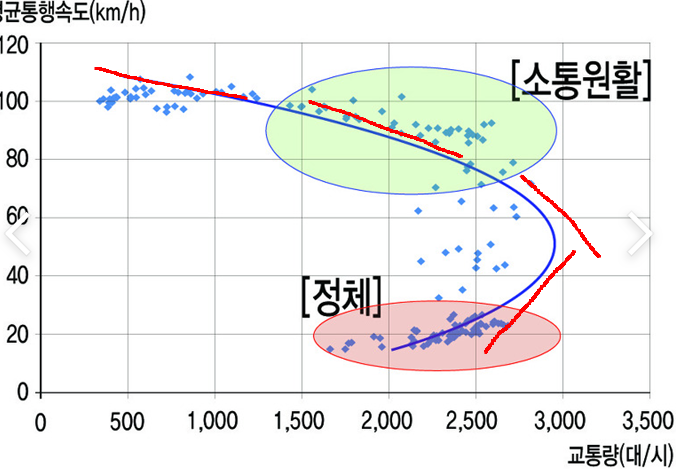

위의 도표에서 보다시피 교통량이 증가하다가 도로의 최대 수용 교통량에 다다랐을 때 속도가 급감하면서 교통량이 다시 줄어드는 구간을 확인할 수 있다. 이 지점을 '임계 교통량'이라 명명하고 이것을 바탕으로 우리가 확인하고자 하는 지점들의 임계 교통량을 조사하였다.

### 3-2) 차선 확대에 따른 임계속도 예측 

### (1) RandomForest 모델 구축

In [ ]:
# 구글 코랩을 사용하였으므로 관련 모듈을 import 시켜준다.
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#기타 필요한 모듈을 import 시켜준다.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
#원본 학습데이터, 차선 +1이 됐을 때 예측할 데이터, 차선-1이 됐을 때 예측할 데이터 총 3개를 준비한다.
df1 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')
df2 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')
df3 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')

In [ ]:
#예측을 위해 차선+1,-1 데이터를 준비
df2['LANES'] = df2['LANES']+1
df3['LANES'] = df3['LANES']-1

In [ ]:
#불필요한 변수 제거
df1 = df1.drop('STREET', axis=1)
df2 = df2.drop('STREET', axis=1)
df3 = df3.drop('STREET', axis=1)

df1 = df1.drop('POINT', axis=1)
df2 = df2.drop('POINT', axis=1)
df3 = df3.drop('POINT', axis=1)

df1 = df1.drop('LONG', axis=1)
df2 = df2.drop('LONG', axis=1)
df3 = df3.drop('LONG', axis=1)

df1 = df1.drop('MAX_SPD', axis=1)
df2 = df2.drop('MAX_SPD', axis=1)
df3 = df3.drop('MAX_SPD', axis=1)

In [ ]:
#train data와 test data를 나눠준다.
df_raw_y = df1['임계 교통량']
df_raw_x = df1.drop("임계 교통량",axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,
                                                             df_raw_y,test_size=0.3,
                                                             random_state=1234)

In [ ]:
#df1에서 원래 lane 수를 학습시키고 df2에서 lane+1, -1 데이터로 임계 교통량을 예측한다.
df_test_x2 = df2.drop("임계 교통량",axis=1,inplace=False)
df_test_x3 = df3.drop("임계 교통량",axis=1,inplace=False)

In [ ]:
#모델 파라미터 조정, n_estimators 트리 수 변경에 따른 모델 성능
#train 및 test 설명력 결과 저장
train_score = []; test_score = []
#n_estimatos : 트리 수 변경 : 1~100
para_n_tree = [n_tree * 1 for n_tree in range(1, 400, 100)]

for v_n_estimators in para_n_tree :
    rf = RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators']=para_n_tree
df_score_n['TrainScore']=train_score
df_score_n['TestScore']=test_score

In [ ]:
#모델 설명력 확인
df_score_n.round(3)

In [ ]:
plt.plot(para_n_tree, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('n_estimators')
plt.legend

In [ ]:
#모델 파라미터 조정, 잎사귀 노드 수
#train 및 test 설명력 결과 저장
train_score = []; test_score = []
#n_estimatos : 트리 수 변경 : 1~100
#para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]
#min_samples_leaf : 잎사귀 최소 자료 수
para_leaf=[n_leaf * 1 for n_leaf in range(1, 110, 10)]

for v_min_samples_leaf in para_leaf :
    rf = RandomForestRegressor(n_estimators = 100, random_state = 1234,
                              min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['min_samples_leaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score

In [ ]:
#모델 설명력 확인
df_score_leaf.round(3)

In [ ]:
plt.plot(para_leaf, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('min_samples_leaf')
plt.legend

In [ ]:
#모델 파라미터 조정, 깊이 수치
#train 및 test 설명력 결과 저장
train_score = []; test_score = []
#n_estimatos : 트리 수 변경 : 1~100
#para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]
#min_samples_leaf : 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth :
    rf = RandomForestRegressor(n_estimators = 100, random_state = 1234,
                               min_samples_leaf=1,
                              max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score

In [ ]:
#모델 설명력 확인
df_score_depth.round(3)

In [ ]:
plt.plot(para_depth, train_score, linestyle='-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle='-', label = 'Test Score')
plt.ylabel('score'); plt.xlabel('max depth')
plt.legend

In [ ]:
#최종 모델 생성
rf_final=RandomForestRegressor(random_state=1234, n_estimators=100, min_samples_leaf=1,
                               max_depth=6)
rf_final.fit(df_train_x, df_train_y)
#train 데이터 설명력
print('Score on training sef: {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))
#test 데이터 설명력
print('Score on test set: {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

In [ ]:
y_pred = rf_final.predict(df_test_x)
print('Accuracy: {:.3f}'.format(rf_final.score(df_test_x,df_test_y)))

In [ ]:
#각각의 예측 데이터를 다른 변수에 저장한다.
prob2 = rf_final.predict(df_test_x2)
prob2 = pd.DataFrame(prob2)

prob3 = rf_final.predict(df_test_x3)
prob3 = pd.DataFrame(prob3)

In [ ]:
rf_final.feature_importances_

In [ ]:
v_feature_name=df_train_x.columns
#설명변수의 중요도
#tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

#df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

In [ ]:
df1['차선+교통량'] = prob2
df1['차선-교통량'] = prob3

In [ ]:
#평균값을 확인해봄으로써 대략적인 수치를 짐작할 수 있다.
df1.describe()

### (2) GradientBoosting 모델 구축

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score,mean_squared_error

# 최대 줄 수 설정
pd.set_option('display.max_rows', 500)
# 최대 열 수 설정
pd.set_option('display.max_columns', 500)
# 표시할 가로의 길이
pd.set_option('display.width', 1000)

In [ ]:
df1 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')
df2 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')
df3 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')

In [ ]:
df2['LANES'] = df2['LANES']+1
df3['LANES'] = df3['LANES']-1

In [ ]:
df1 = df1.drop('STREET', axis=1)
df2 = df2.drop('STREET', axis=1)
df3 = df3.drop('STREET', axis=1)

df1 = df1.drop('POINT', axis=1)
df2 = df2.drop('POINT', axis=1)
df3 = df3.drop('POINT', axis=1)

df1 = df1.drop('LONG', axis=1)
df2 = df2.drop('LONG', axis=1)
df3 = df3.drop('LONG', axis=1)

df1 = df1.drop('MAX_SPD', axis=1)
df2 = df2.drop('MAX_SPD', axis=1)
df3 = df3.drop('MAX_SPD', axis=1)

In [ ]:
df_raw_y = df1['임계 교통량']
df_raw_x = df1.drop("임계 교통량",axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,
                                                             df_raw_y,test_size=0.3,
                                                             random_state=1234)

In [ ]:
#df1에서 원래 lane 수를 학습시키고 df2에서 lane+1,-1 데이터로 임계 교통량을 예측한다.
df_test_x2 = df2.drop("임계 교통량",axis=1,inplace=False)
df_test_x3 = df3.drop("임계 교통량",axis=1,inplace=False)

In [ ]:
train_accuracy = []; test_accuracy=[]

para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(learning_rate=v_learning_rate, random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainScore']=train_accuracy
df_accuracy_lr['TestScore']=test_accuracy

In [ ]:
df_accuracy_lr.round(3)

In [ ]:
plt.plot(para_lr, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('learning rate') # estimators : 추정량
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree :
    gb = GradientBoostingRegressor(n_estimators=v_n_estimators, learning_rate = 0.4,
             random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['Estimators'] = para_n_tree
df_accuracy_n['TrainScore']=train_accuracy
df_accuracy_n['TestScore']=test_accuracy

In [ ]:
df_accuracy_n.round(3)

In [ ]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('n_estimators') # estimators : 추정량
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    gb = GradientBoostingRegressor(max_depth = v_max_depth, n_estimators = 100, learning_rate = 0.4,
             random_state=1234)
    gb.fit(df_train_x,df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainScore']=train_accuracy
df_accuracy_depth['TestScore']=test_accuracy

In [ ]:
df_accuracy_depth.round(3)

In [ ]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('depth')
plt.legend()

In [ ]:
gb_final = GradientBoostingRegressor(max_depth = 4, n_estimators = 100, learning_rate = 0.4, random_state=1234)
gb_final.fit(df_train_x,df_train_y)
y_pred  = gb_final.predict(df_test_x)

print("Train Acc : {:.3f}".format(gb_final.score(df_train_x,df_train_y)))
print("Test Acc : {:.3f}".format(gb_final.score(df_test_x,df_test_y)))

In [ ]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance.round(3)

In [ ]:
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('variable Importance')
plt.ylabel('variable')

In [ ]:
prob2 = gb_final.predict(df_test_x2)
prob2 = pd.DataFrame(prob2)

prob3 = gb_final.predict(df_test_x3)
prob3 = pd.DataFrame(prob3)

In [ ]:
df1.reset_index(inplace=True)

In [ ]:
df1['차선+교통량'] = prob2
df1['차선-교통량'] = prob3

In [ ]:
df1.describe()

In [ ]:
df1.to_csv('/content/gdrive/MyDrive/bigdata_contest/prob1_gb.csv', encoding = 'euc-kr')

### (3) XGBoosting 모델 구축

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd

In [ ]:
df1 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')
df2 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')
df3 = pd.read_csv('/content/gdrive/MyDrive/bigdata_contest/test.csv', engine='python', encoding = 'euc-kr')

In [ ]:
df2['LANES'] = df2['LANES']+1
df3['LANES'] = df3['LANES']-1

In [ ]:
df1 = df1.drop('STREET', axis=1)
df2 = df2.drop('STREET', axis=1)
df3 = df3.drop('STREET', axis=1)

df1 = df1.drop('POINT', axis=1)
df2 = df2.drop('POINT', axis=1)
df3 = df3.drop('POINT', axis=1)

df1 = df1.drop('LONG', axis=1)
df2 = df2.drop('LONG', axis=1)
df3 = df3.drop('LONG', axis=1)

df1 = df1.drop('MAX_SPD', axis=1)
df2 = df2.drop('MAX_SPD', axis=1)
df3 = df3.drop('MAX_SPD', axis=1)

In [ ]:
df_raw_y = df1['임계 교통량']
df_raw_x = df1.drop("임계 교통량",axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,
                                                             df_raw_y,test_size=0.3,
                                                             random_state=1234)

In [ ]:
#df1에서 원래 lane 수를 학습시키고 df2에서 lane+1,-1 데이터로 임계 교통량을 예측한다.
df_test_x2 = df2.drop("임계 교통량",axis=1,inplace=False)
df_test_x3 = df3.drop("임계 교통량",axis=1,inplace=False)

In [ ]:
train_accuracy = []; test_accuracy=[]

para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    xg = xgboost.XGBRegressor(learning_rate=v_learning_rate, random_state=1234)
    xg.fit(df_train_x,df_train_y)
    train_accuracy.append(xg.score(df_train_x,df_train_y))
    test_accuracy.append(xg.score(df_test_x,df_test_y))
    
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainScore']=train_accuracy
df_accuracy_lr['TestScore']=test_accuracy

In [ ]:
df_accuracy_lr.round(3)

In [ ]:
plt.plot(para_lr, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('learning rate') # estimators : 추정량
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree :
    xg = xgboost.XGBRegressor(n_estimators=v_n_estimators, learning_rate = 0.6,
             random_state=1234)
    xg.fit(df_train_x,df_train_y)
    train_accuracy.append(xg.score(df_train_x,df_train_y))
    test_accuracy.append(xg.score(df_test_x,df_test_y))
    
df_accuracy_n = pd.DataFrame()
df_accuracy_n['Estimators'] = para_n_tree
df_accuracy_n['TrainScore']=train_accuracy
df_accuracy_n['TestScore']=test_accuracy

In [ ]:
df_accuracy_n.round(3)

In [ ]:
plt.plot(para_n_tree, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('n_estimators') # estimators : 추정량
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth :
    xg = xgboost.XGBRegressor(max_depth = v_max_depth, n_estimators = 80, learning_rate = 0.6,
             random_state=1234)
    xg.fit(df_train_x,df_train_y)
    train_accuracy.append(xg.score(df_train_x,df_train_y))
    test_accuracy.append(xg.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainScore']=train_accuracy
df_accuracy_depth['TestScore']=test_accuracy

In [ ]:
df_accuracy_depth.round(3)

In [ ]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('depth')
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_gamma = [gamma1*0.01 for gamma1 in range(1,10)]

for ga in para_gamma :
    xg = xgboost.XGBRegressor(gamma = ga, max_depth = 3, n_estimators = 80, learning_rate = 0.6,
             random_state=1234)
    xg.fit(df_train_x,df_train_y)
    train_accuracy.append(xg.score(df_train_x,df_train_y))
    test_accuracy.append(xg.score(df_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma['Gamma'] = para_gamma
df_accuracy_gamma['TrainScore']=train_accuracy
df_accuracy_gamma['TestScore']=test_accuracy

In [ ]:
df_accuracy_gamma.round(3)

In [ ]:
plt.plot(para_gamma, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_gamma, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('gamma')
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_subsample = [subsample1*0.1 for subsample1 in range(1,10)]

for subsample2 in para_subsample :
    xg = xgboost.XGBRegressor(subsample = subsample2, max_depth = 3, n_estimators = 80, learning_rate = 0.6,
             random_state=1234)
    xg.fit(df_train_x,df_train_y)
    train_accuracy.append(xg.score(df_train_x,df_train_y))
    test_accuracy.append(xg.score(df_test_x,df_test_y))
    
df_accuracy_subsample = pd.DataFrame()
df_accuracy_subsample['Subsample'] = para_subsample
df_accuracy_subsample['TrainScore']=train_accuracy
df_accuracy_subsample['TestScore']=test_accuracy

In [ ]:
df_accuracy_subsample.round(3)

In [ ]:
plt.plot(para_subsample, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_subsample, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('subsample')
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy=[]

para_bytree = [value1*0.1 for value1 in range(1,10)]

for value2 in para_bytree :
    xg = xgboost.XGBRegressor(colsample_bytree = value2, subsample = 0.7, max_depth = 3, n_estimators = 80, learning_rate = 0.6,
             random_state=1234)
    xg.fit(df_train_x,df_train_y)
    train_accuracy.append(xg.score(df_train_x,df_train_y))
    test_accuracy.append(xg.score(df_test_x,df_test_y))
    
df_accuracy_bytree = pd.DataFrame()
df_accuracy_bytree['bytree'] = para_bytree
df_accuracy_bytree['TrainScore']=train_accuracy
df_accuracy_bytree['TestScore']=test_accuracy

In [ ]:
df_accuracy_bytree.round(3)

In [ ]:
plt.plot(para_bytree, train_accuracy, linestyle="-", label = 'Train Accuracy')
plt.plot(para_bytree, test_accuracy, linestyle="--", label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('bytree')
plt.legend()

In [ ]:
xg_final = xgboost.XGBRegressor(n_estimators=80, learning_rate=0.6, gamma=0, subsample=0.7,
                           colsample_bytree=0.7, max_depth=3)
xg_final.fit(df_train_x,df_train_y)
y_pred  = xg_final.predict(df_test_x)

print("Train Acc : {:.3f}".format(xg_final.score(df_train_x,df_train_y)))
print("Test Acc : {:.3f}".format(xg_final.score(df_test_x,df_test_y)))

In [ ]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = xg_final.feature_importances_
df_importance.sort_values('Importance',ascending=False,inplace=True)
df_importance.round(3)

In [ ]:
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates,df_importance['Feature'])
plt.xlabel('variable Importance')
plt.ylabel('variable')

In [ ]:
prob2 = xg_final.predict(df_test_x2)
prob2 = pd.DataFrame(prob2)

prob3 = xg_final.predict(df_test_x3)
prob3 = pd.DataFrame(prob3)

In [ ]:
df1.reset_index(inplace=True)

In [ ]:
df1['차선+교통량'] = prob2
df1['차선-교통량'] = prob3

In [ ]:
df1.describe()

In [ ]:
df1.to_csv('/content/gdrive/MyDrive/bigdata_contest/prob1_xg.csv', encoding = 'euc-kr')

변수 중요도를 봤을 때, 임계 교통량은 차선보다 신호등이나 진입로에 더 큰 영향을 받는다. 그러나 이번 프로젝트에서는 차선과의 상호관계를 파악하는 것이 목적이므로 차선 중요도가 더 높은 모델인 XGB를 사용하여 예측해보았다.

---

# 결론

## 5. 로드지퍼 활용 방안  

### 5-1) 로드지퍼 활용 방안